In [ ]:
!pip install opencv-python
!pip  install tensorflow

In [5]:
import os
os.makedirs('TEST/YES',exist_ok=True)
os.makedirs('TRAIN/YES',exist_ok=True)
os.makedirs('VAL/YES',exist_ok=True)
os.makedirs('TEST/NO',exist_ok=True)
os.makedirs('TRAIN/NO',exist_ok=True)
os.makedirs('VAL/NO',exist_ok=True)


In [6]:

import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [7]:
path_to_yes = 'C:/Users/Ivar/Downloads/brain_tumor_dataset/data/YES/*.jpg'
path_to_no = "C:/Users/Ivar/Downloads/brain_tumor_dataset/data/NO/*.jpg"

# Initialize lists to store tumor and non-tumor images
tumor = []
no_tumor = []

for file in glob.iglob(path_to_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))  # Resize all images to (128, 128)
    tumor.append(img)

for file in glob.iglob(path_to_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))  # Resize all images to (128, 128)
    no_tumor.append(img)



In [8]:
tumor=np.array(tumor)
no_tumor=np.array(no_tumor)
all_data = np.concatenate((tumor, no_tumor), axis=0)


labels = np.concatenate([np.ones(len(tumor)), np.zeros(len(no_tumor))])  # Assign labels
print(all_data.shape)
print(labels.shape)

(245, 128, 128, 3)
(245,)


In [9]:
#visuall
tumor=np.array(tumor)
no_tumor=np.array(no_tumor)
def plot_img(tumor,no_tumor,num=5):
    healty_image=no_tumor[np.random.choice(no_tumor.shape[0],num,replace=False)]
    tumor_image=tumor[np.random.choice(tumor.shape[0],num,replace=False)]
    plt.figure(figsize=(15,6))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title("healty_image")
        plt.imshow(healty_image[i])
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title("tumor_mage")
        plt.imshow(tumor_image[i])


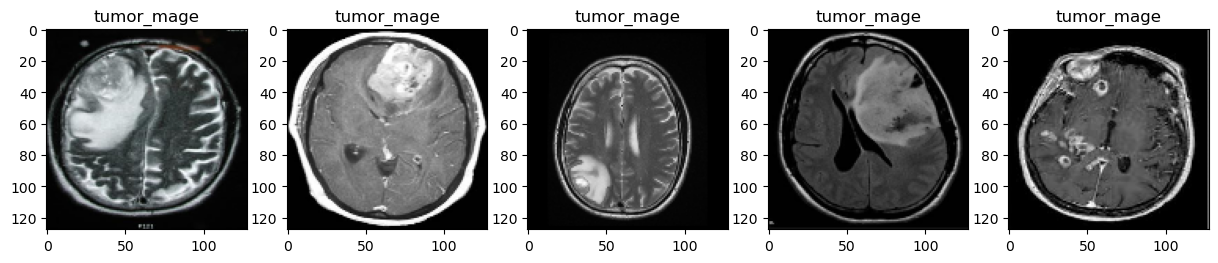

In [10]:

plot_img(tumor,no_tumor,num=5)

In [11]:
all_data_shuffled, labels_shuffled = shuffle(all_data, labels, random_state=42)
x_train_val, x_test, y_train_val, y_test = train_test_split(all_data_shuffled, labels_shuffled, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.3, random_state=42)



In [12]:

print("Train data shape:", x_train.shape)
print("validate shape:", x_val.shape)
print("test data shape:", x_test.shape)
print(" train labels shape:", y_train.shape)
print("Validation data shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (145, 128, 128, 3)
validate shape: (63, 128, 128, 3)
test data shape: (37, 128, 128, 3)
 train labels shape: (145,)
Validation data shape: (63,)
Test labels shape: (37,)


In [13]:
#save image
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [14]:
print(np.max(x_train))
#data nozmalazation 
#x_train=x_train/255
#x_val=x_val/255
#x_test=x_test/255
save_new_images(x_train, y_train, folder_name='TRAIN/')
save_new_images(x_val, y_val, folder_name='VAL/')
save_new_images(x_test, y_test, folder_name='TEST/')
print(x_train.shape)

255
(145, 128, 128, 3)


In [15]:
#data_augmentation firt set the parameters 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)



In [16]:
print(x_train.shape)
print(x_train[0].shape)

(145, 128, 128, 3)
(128, 128, 3)


In [17]:
os.makedirs('preview',exist_ok=True)
x=x_train[0]
x = x.reshape((1,) + x.shape) 

print(x.shape)
i=0

for batch in image_augmentor.flow(x,batch_size=1,save_to_dir='preview',save_prefix='aug_img',save_format='jpg'):
    i+=1
    if i >20:
        break



(1, 128, 128, 3)


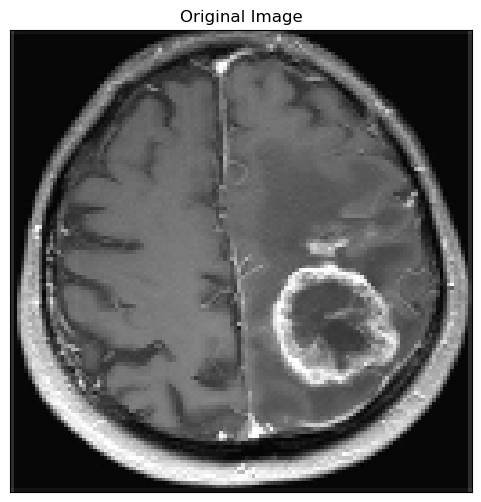

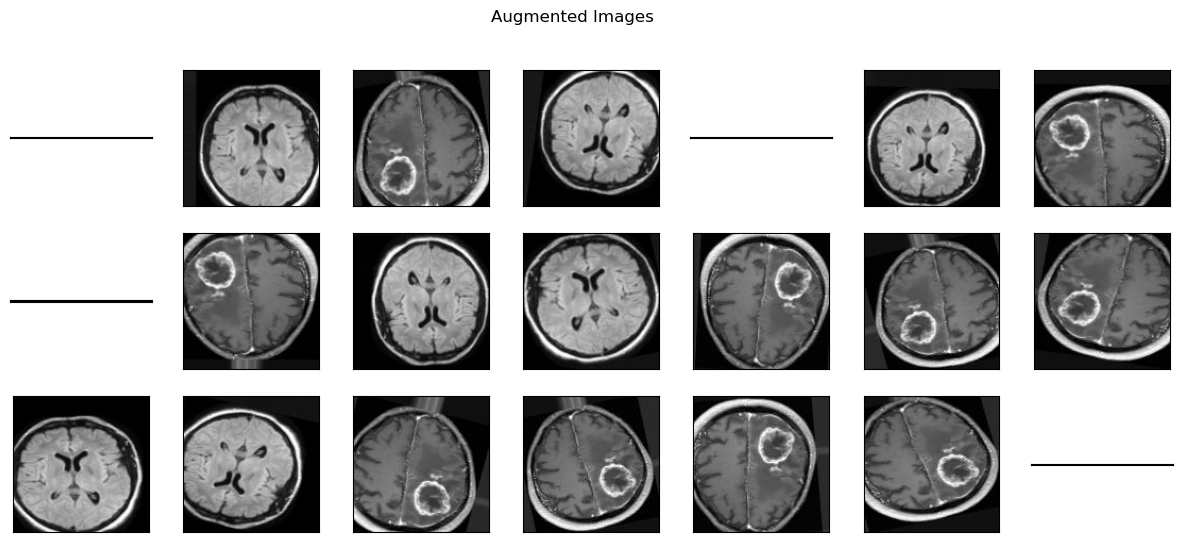

In [18]:

plt.figure(figsize=(6, 6))
plt.imshow(x_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Display augmented images
plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview/'):
    img = cv2.imread(os.path.join('preview', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [19]:
# now put then in train folder
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
#from keras.applications.inception_v3 import InceptionV3,inception_v3
#from keras.applications.resnet50 import ResNet50,resnet50

TRAIN_DIR = 'TRAIN/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

train_image_augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_image_augmentor = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_image_augmentor.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=42
)


validation_generator = test_image_augmentor.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=42
)



Found 145 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [20]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


In [21]:
# load base model
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

IMG_SIZE = (224,224)
vgg = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)
vgg.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_99>

In [22]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC,
            
  
        )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
       
        set_new.append(preprocess_input(img))
    return np.array(set_new)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


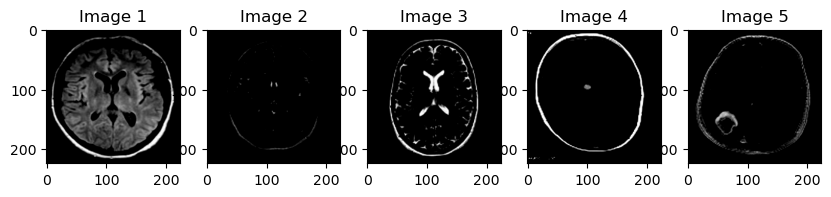

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


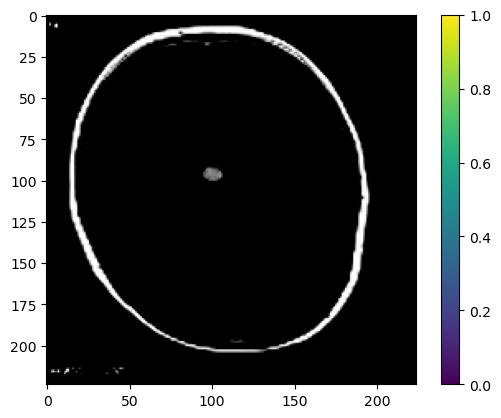

In [27]:
X_train_prep = preprocess_imgs(set_name=x_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=x_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=x_val, img_size=IMG_SIZE)

num_images_to_plot = 5

plt.figure(figsize=(10, 10))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(X_test_prep[i])

    plt.title(f'Image {i + 1}')  # Set title for each image

plt.show()
plt.imshow(X_test_prep[3])

plt.colorbar()
plt.show()

In [28]:
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims
model = VGG16()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,792 (7.00 KB)

 Trainable params: 1,792 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


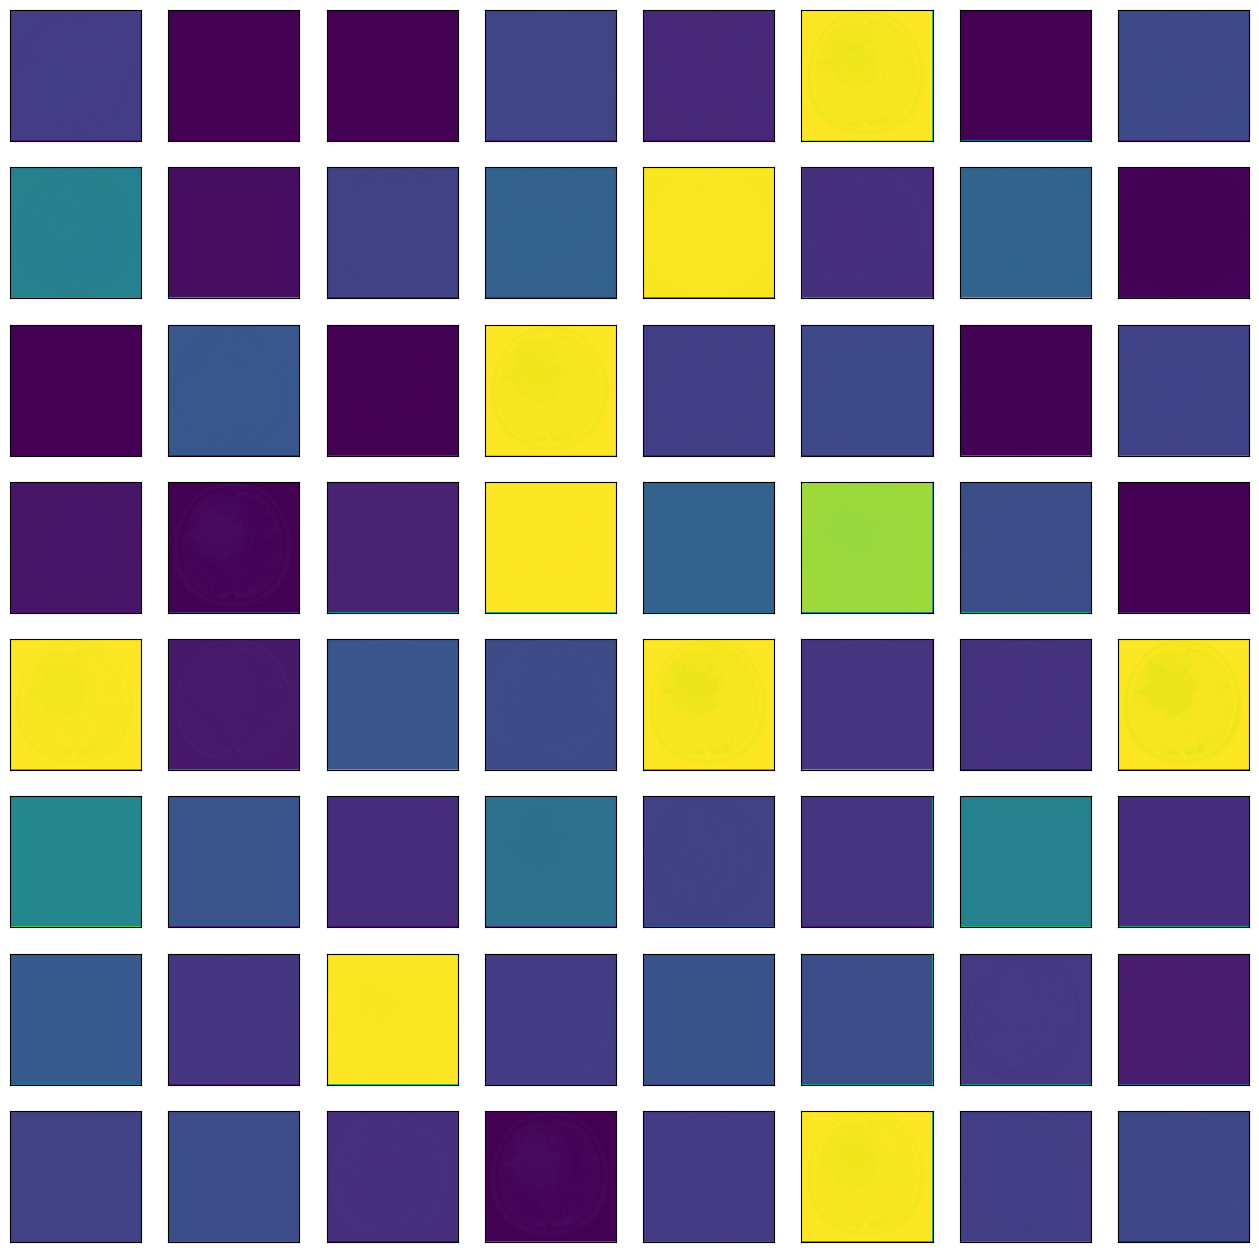

In [25]:
#we use the model from the above VGG16  AND Model from keras.model
from matplotlib import pyplot
f = plt.figure(figsize=(16,16))
model = VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[1].output)
model.summary()
#add one dim and preprocess to be compatably with the vgg
image = img_to_array(X_train_prep[5])
image = expand_dims(image, axis=0)
image=preprocess_input(image)
image=model.predict(image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
# specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(image[0, :, :, ix-1], cmap='viridis')
        ix += 1
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


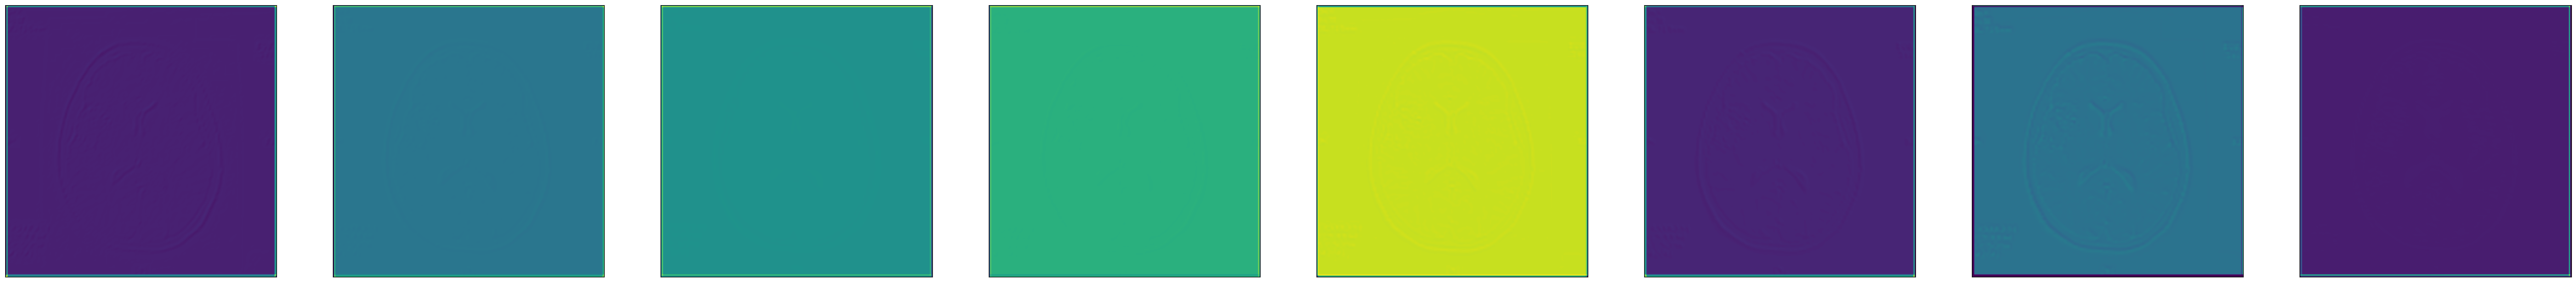

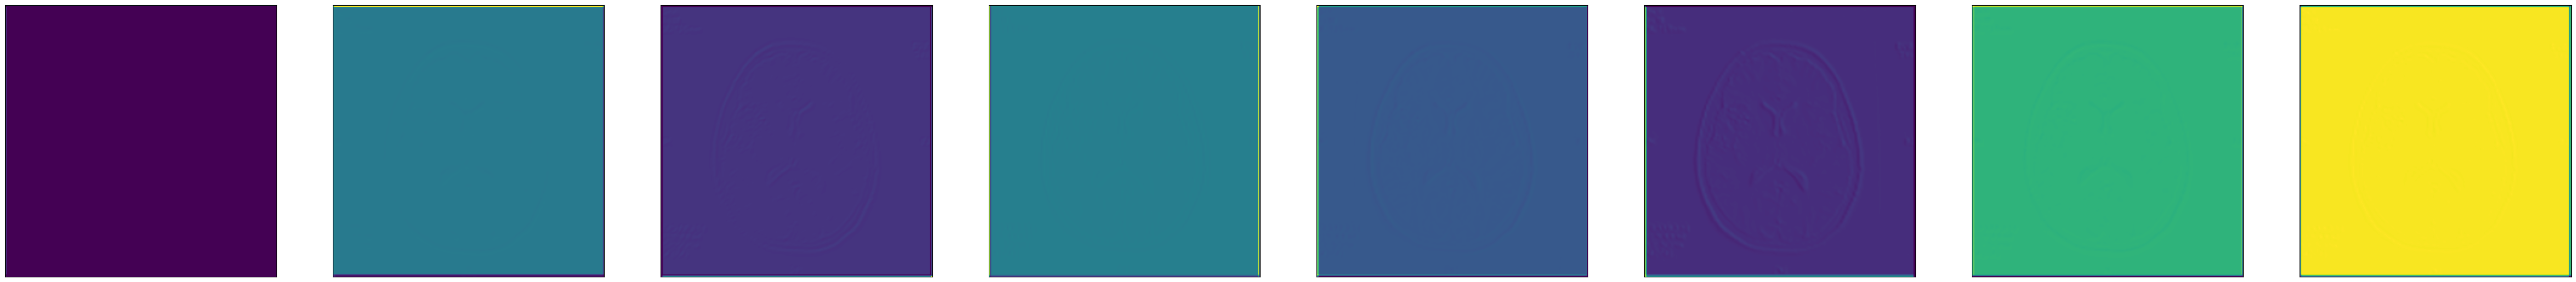

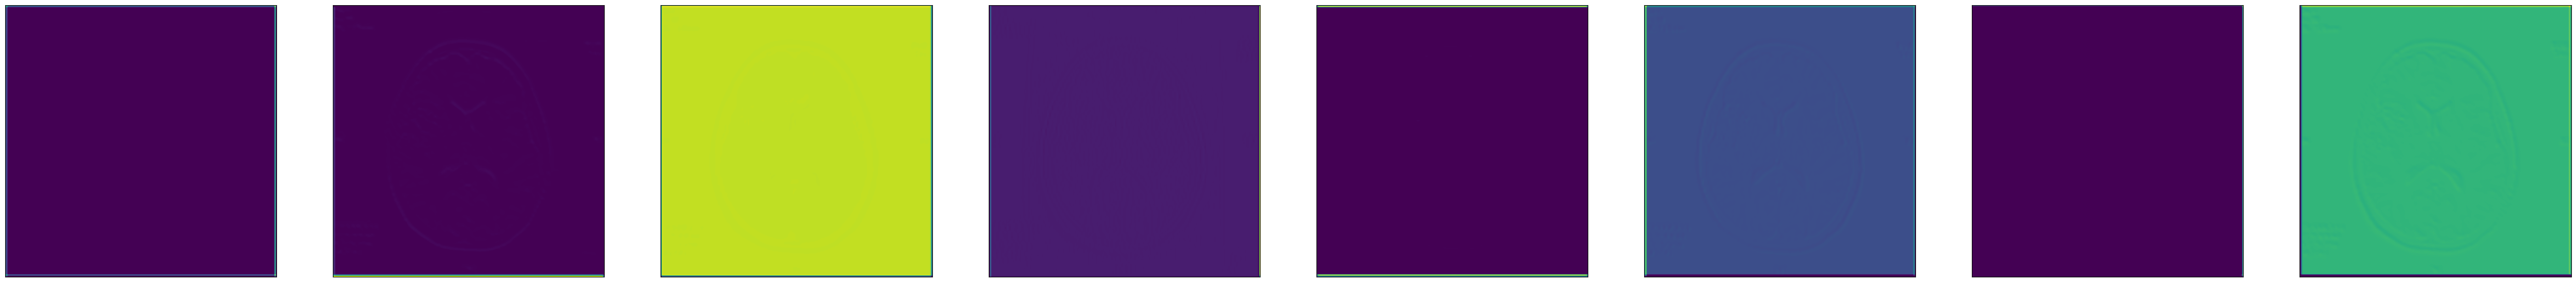

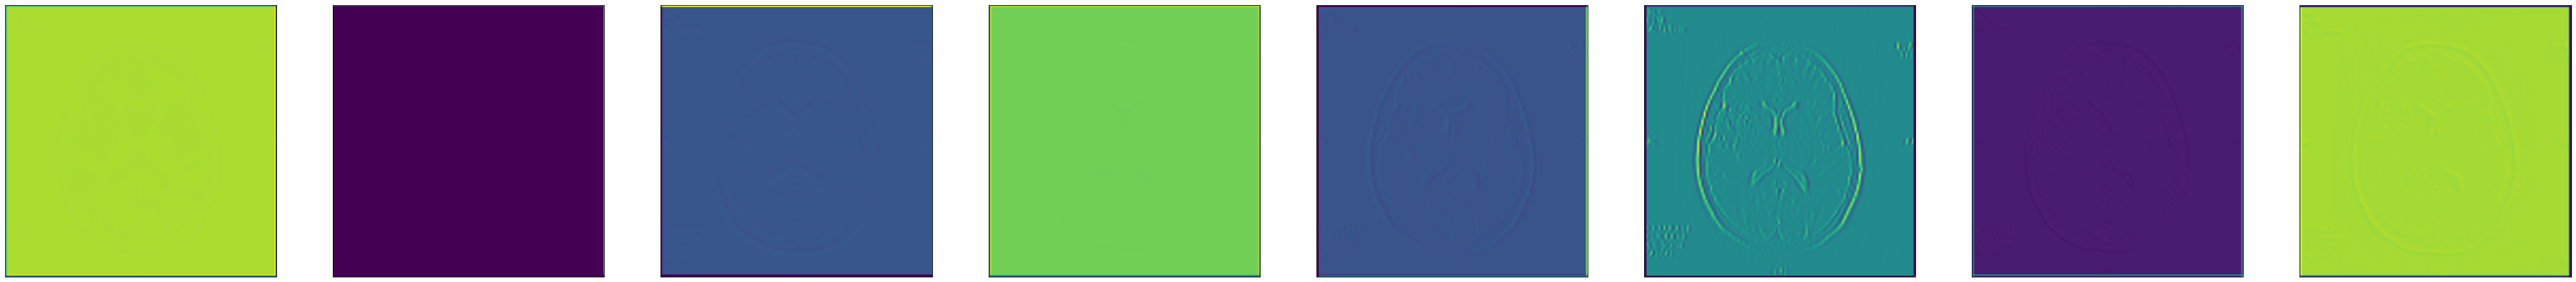

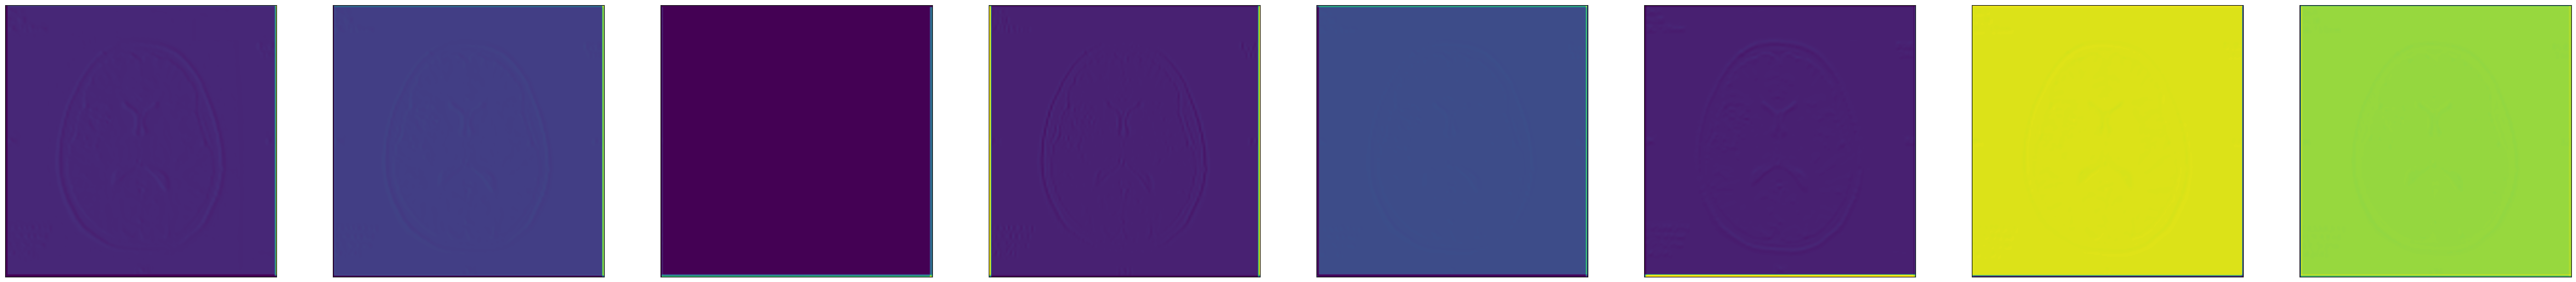

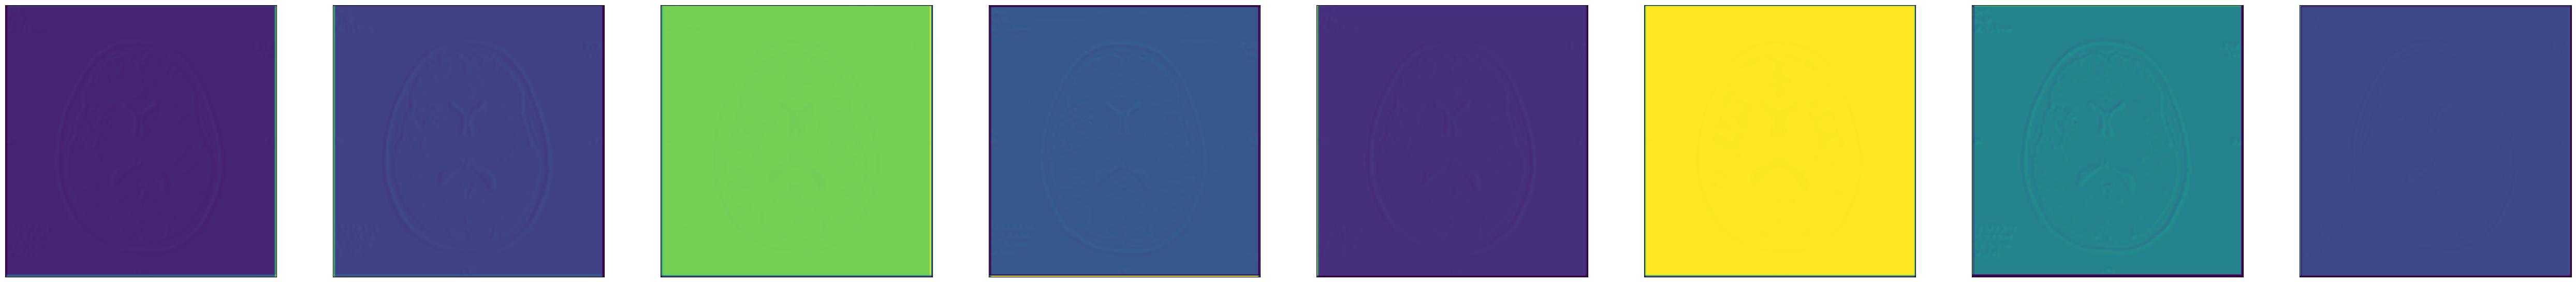

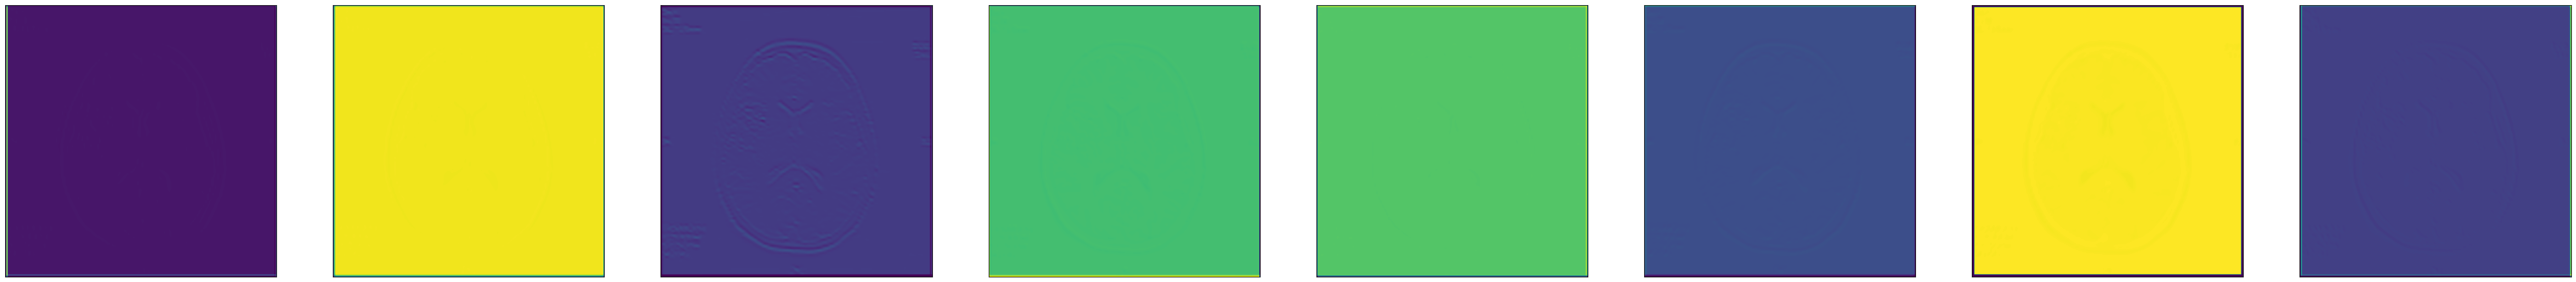

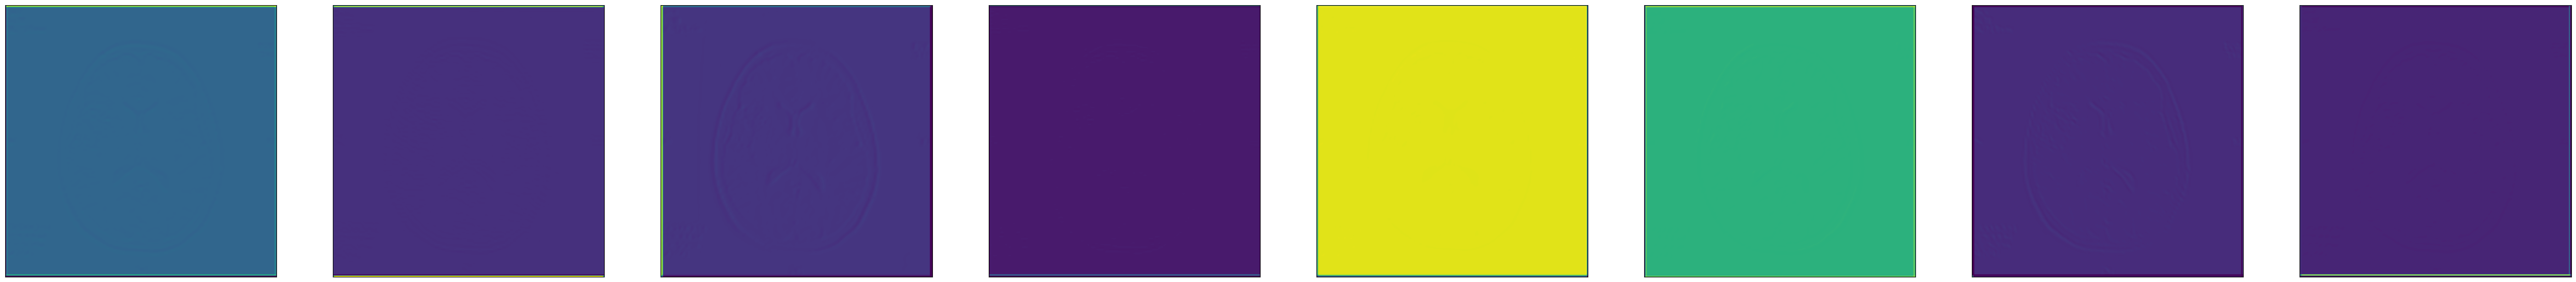

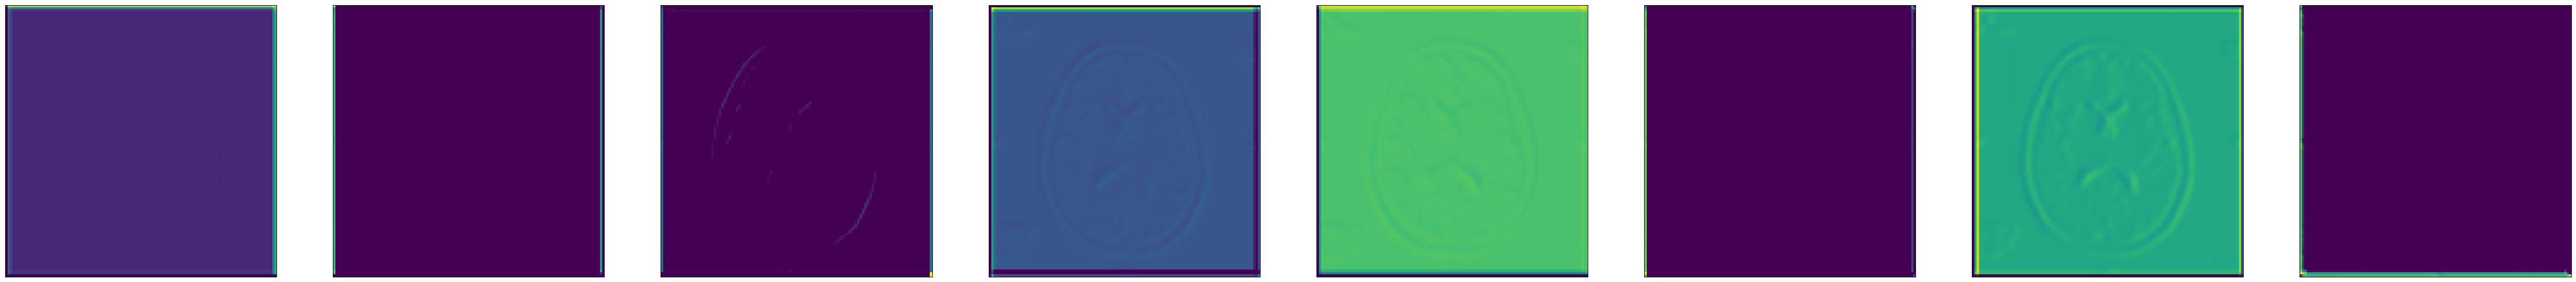

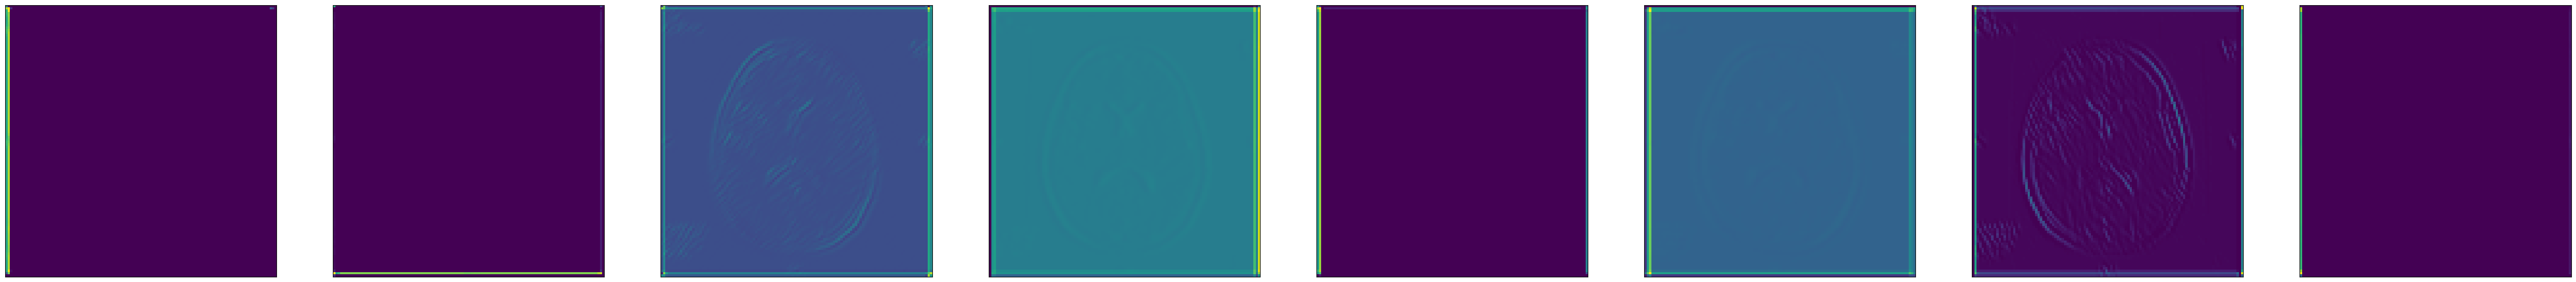

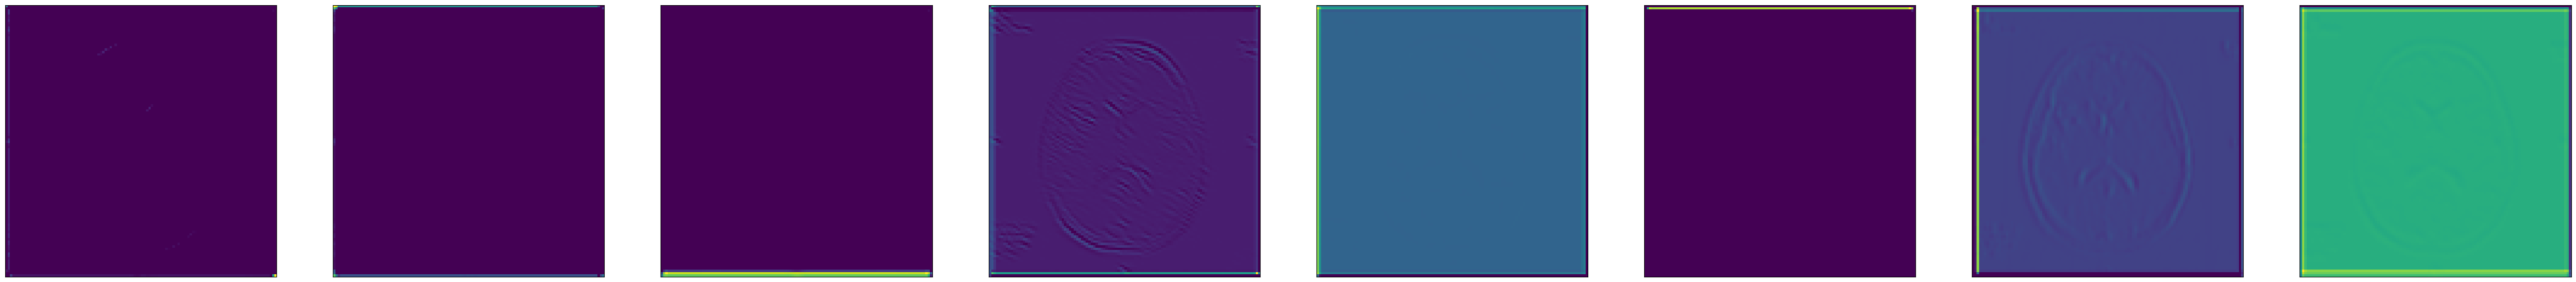

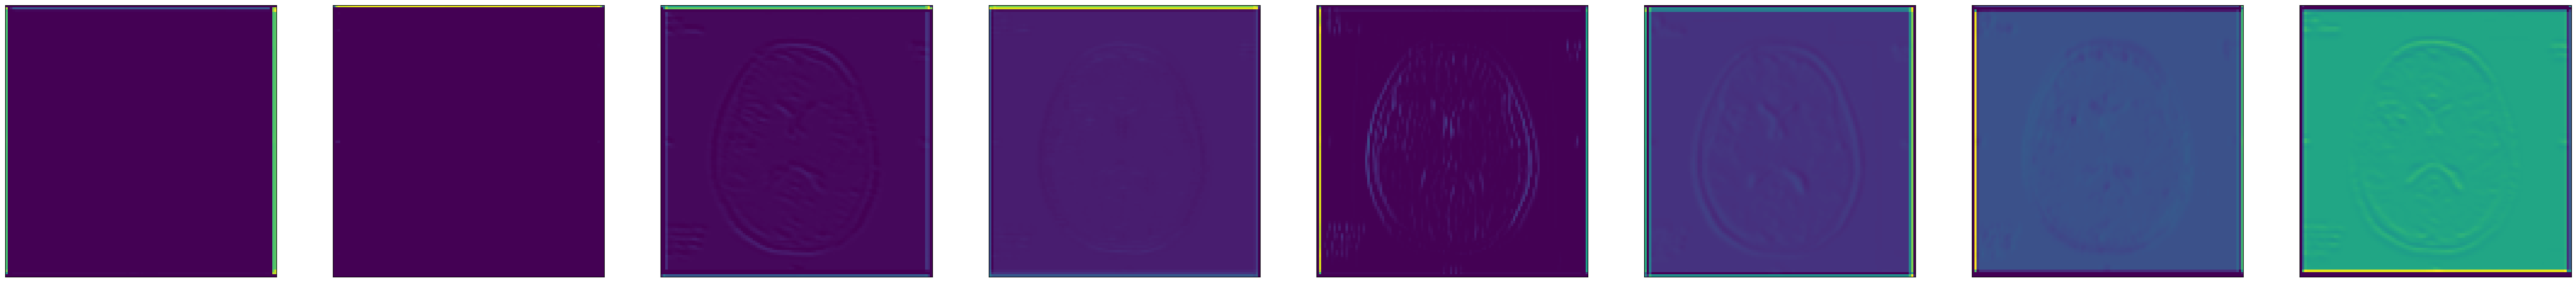

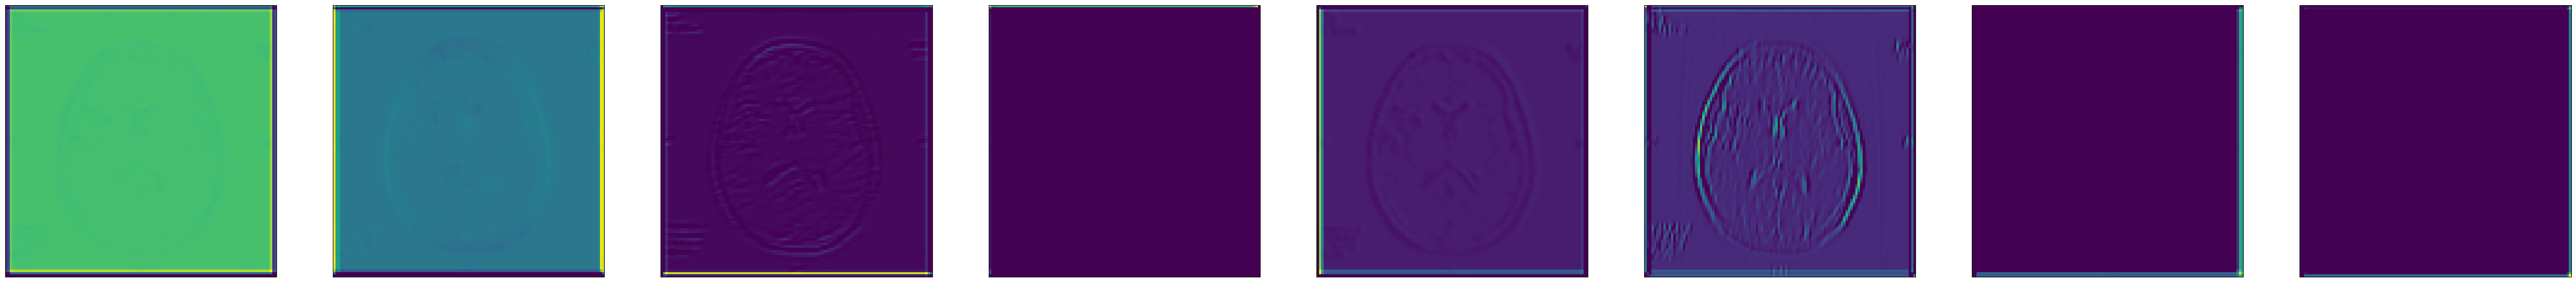

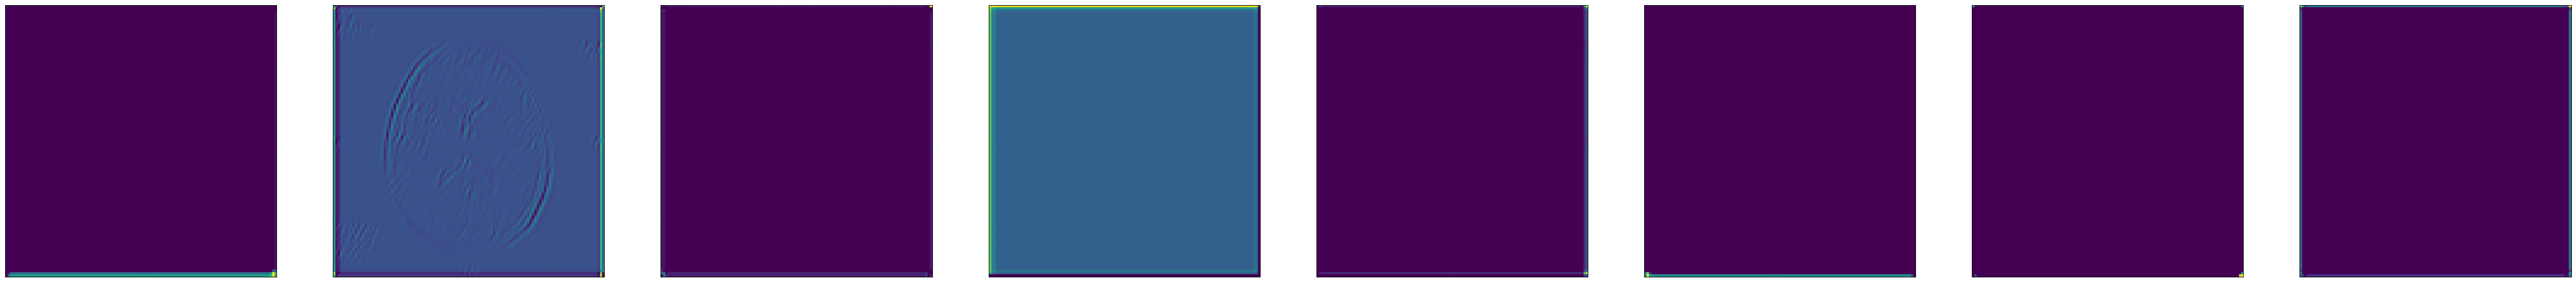

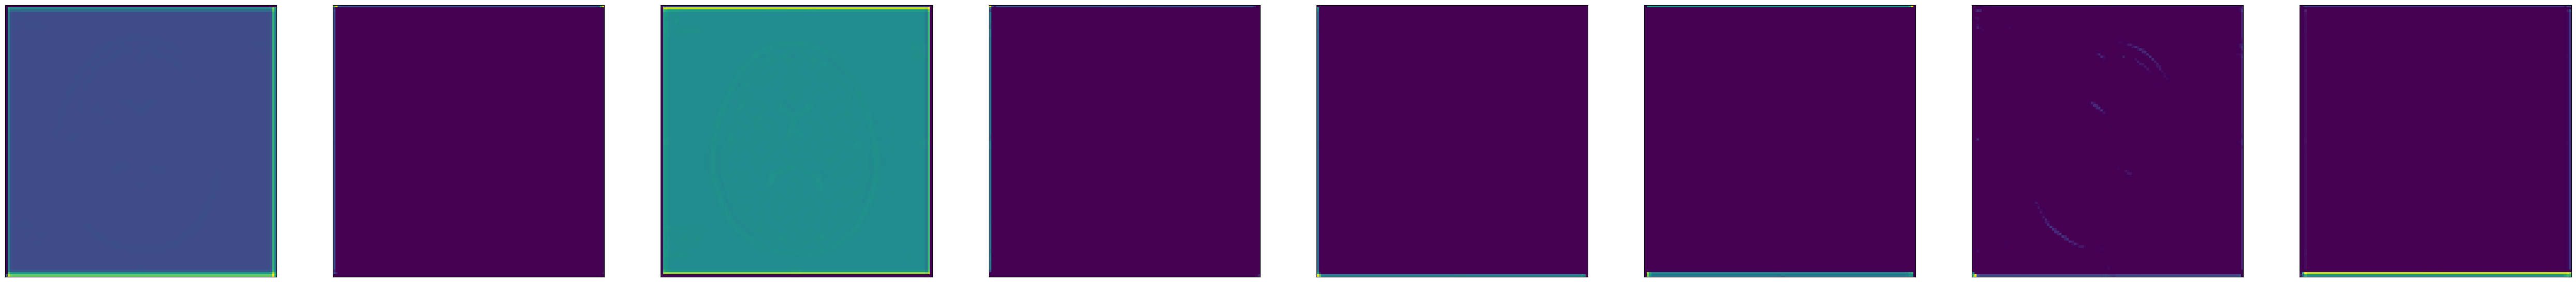

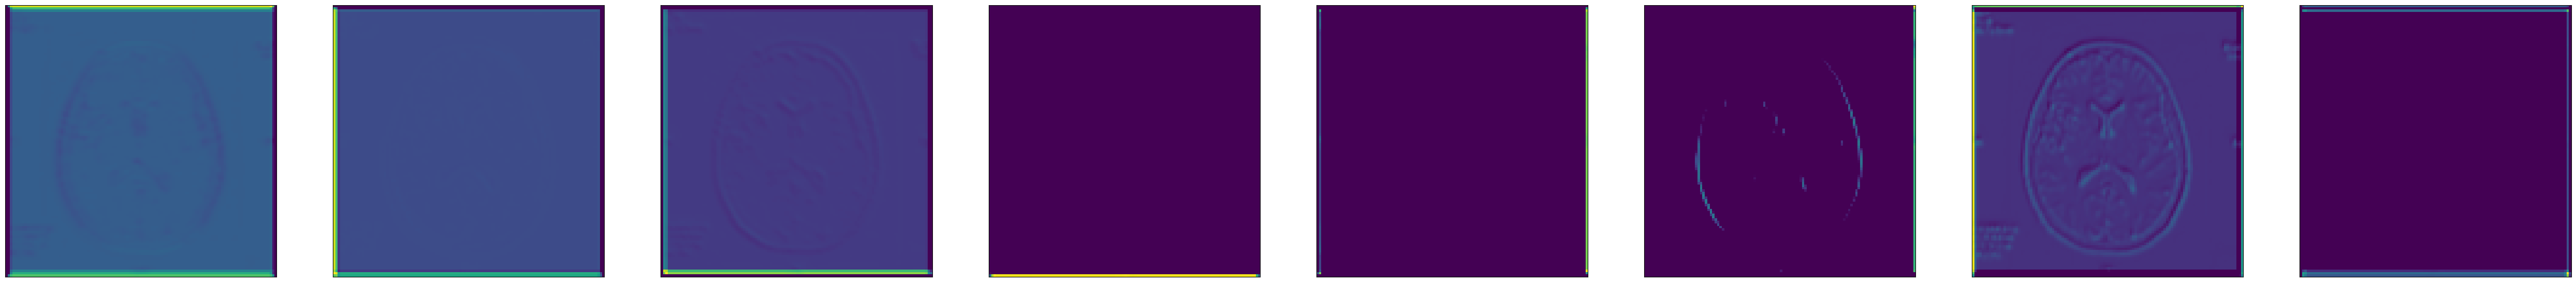

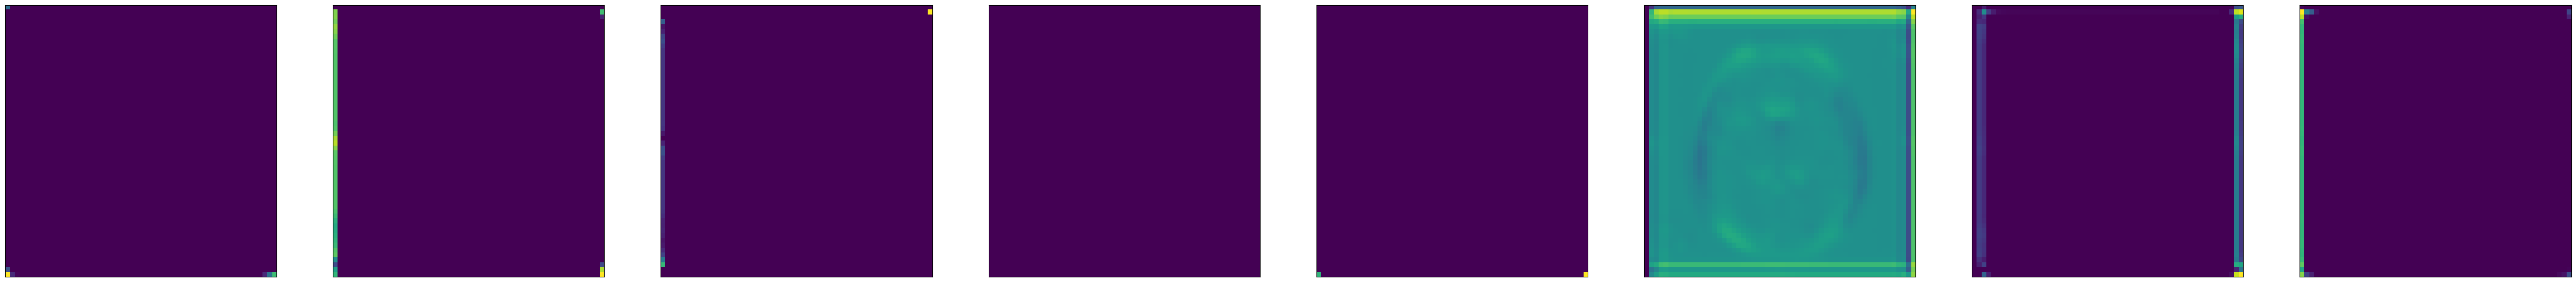

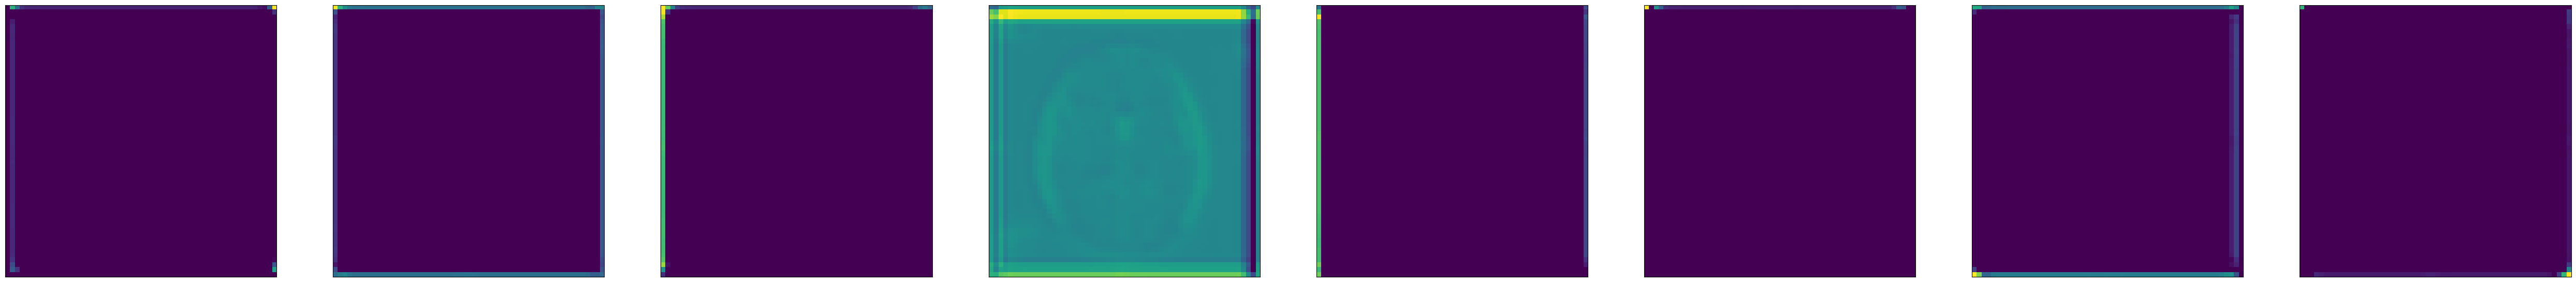

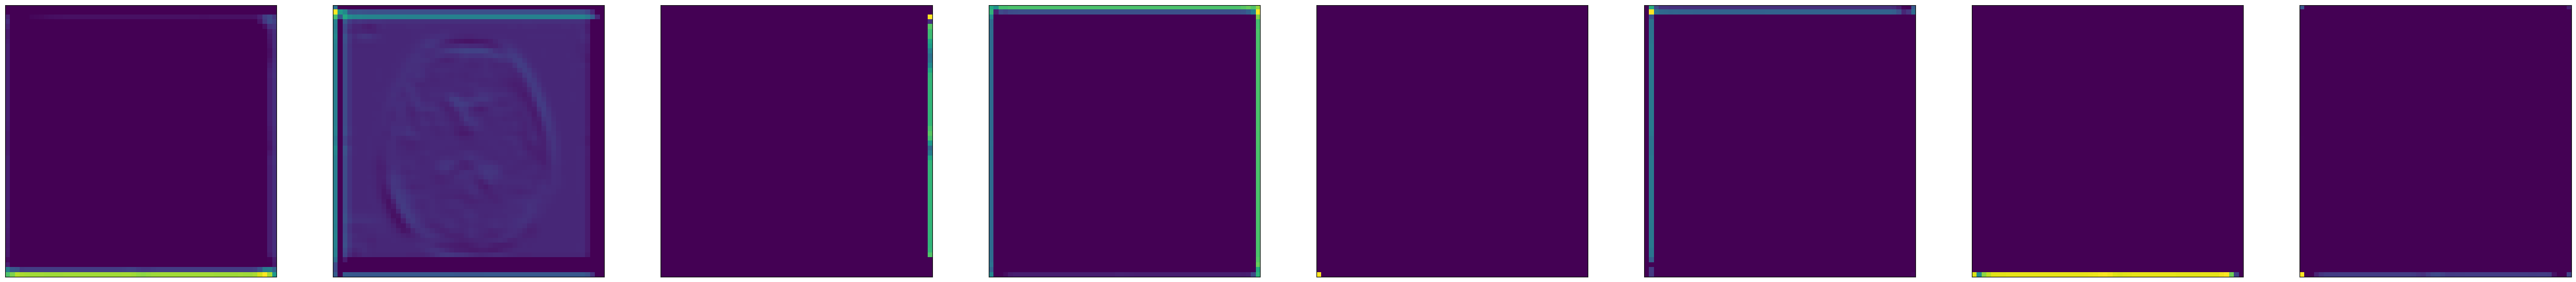

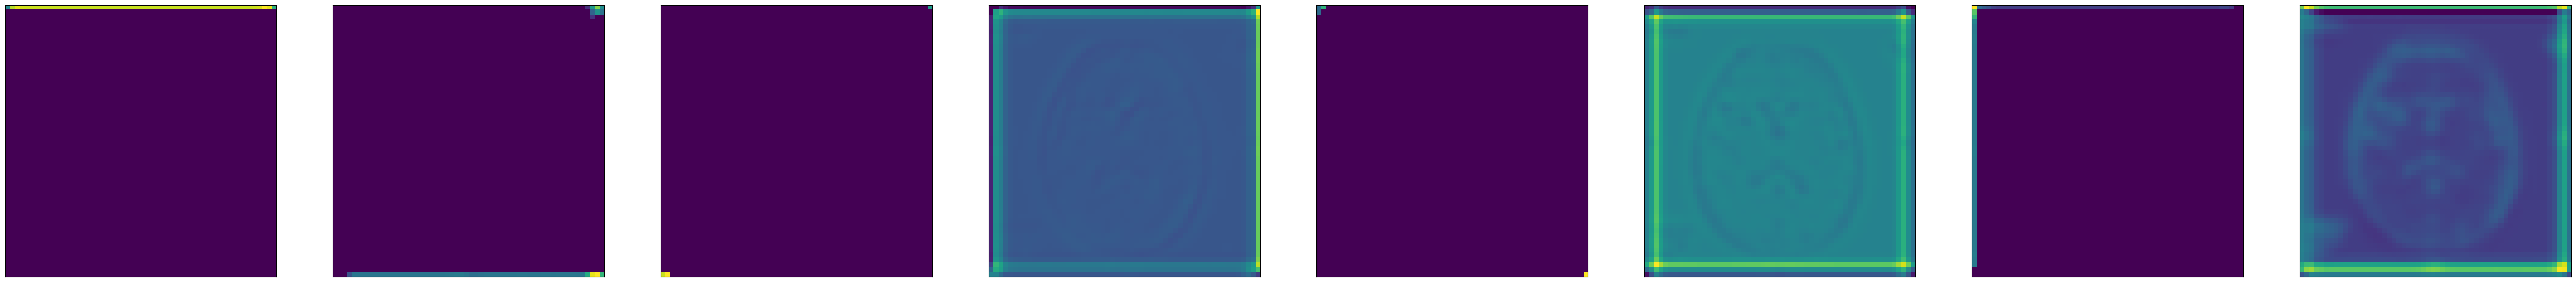

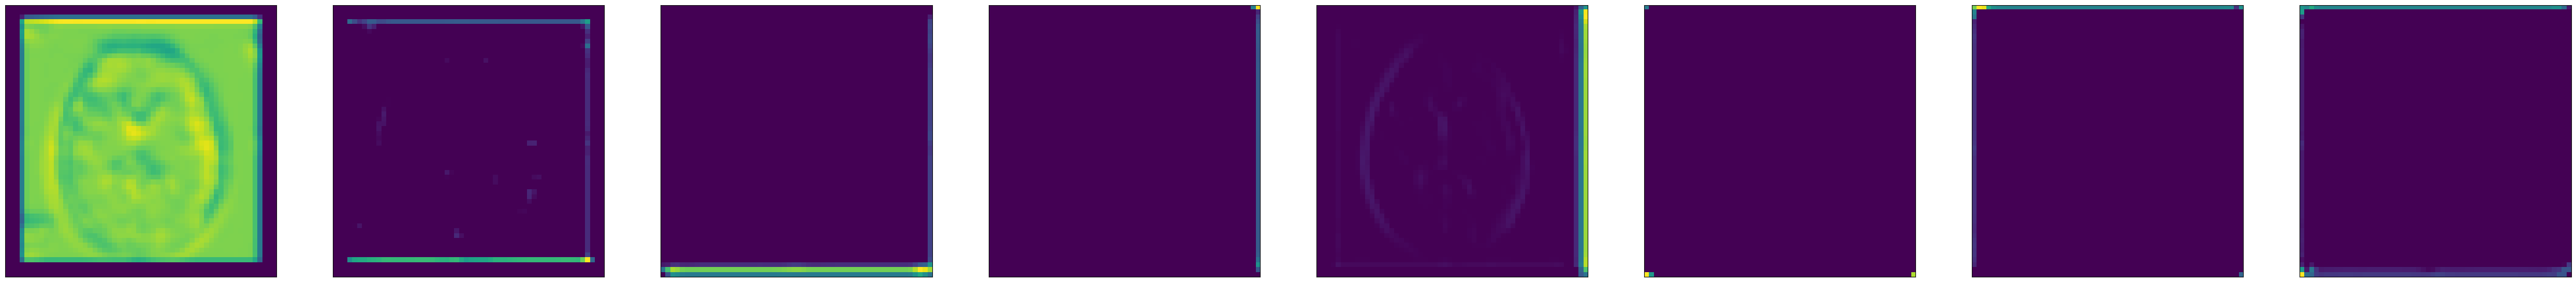

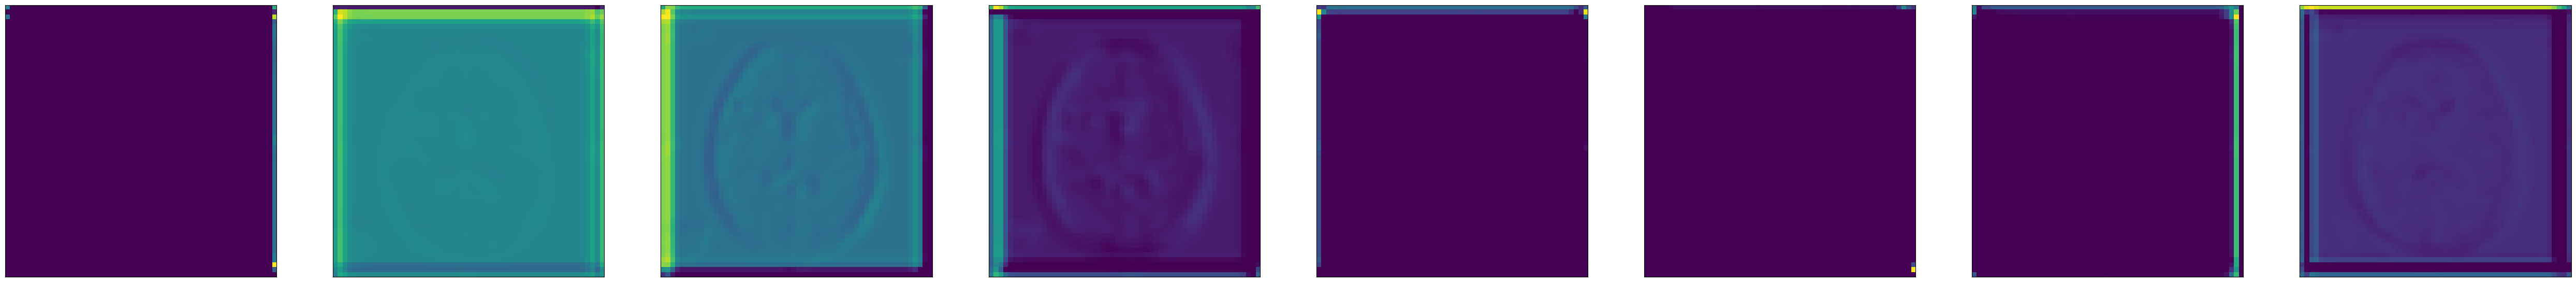

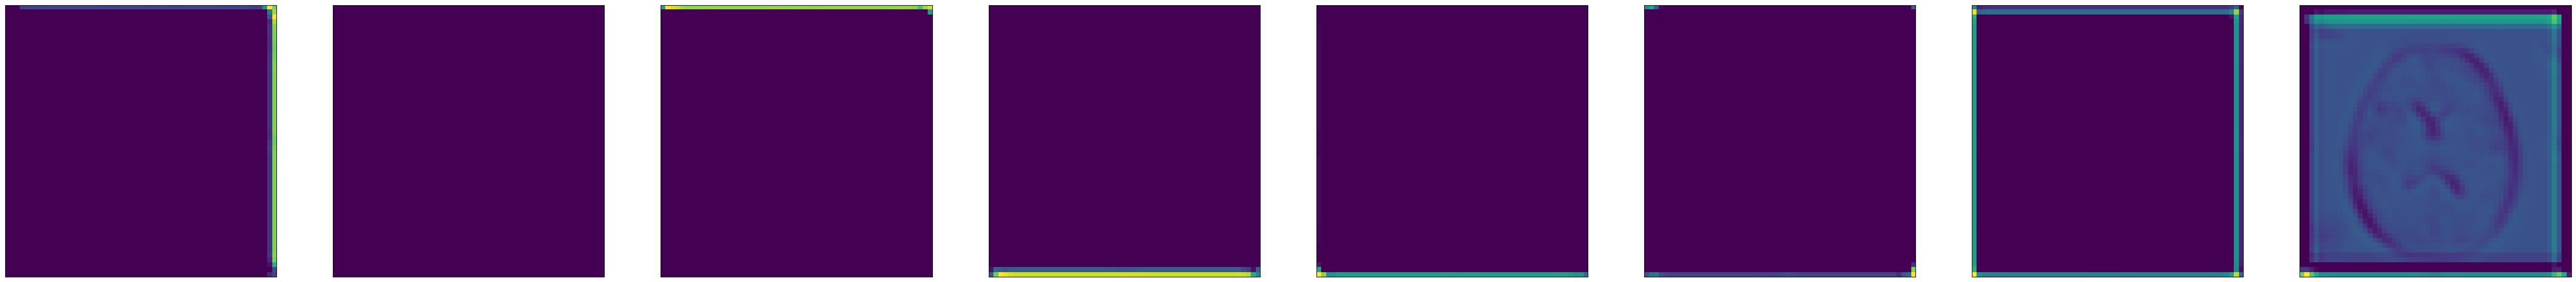

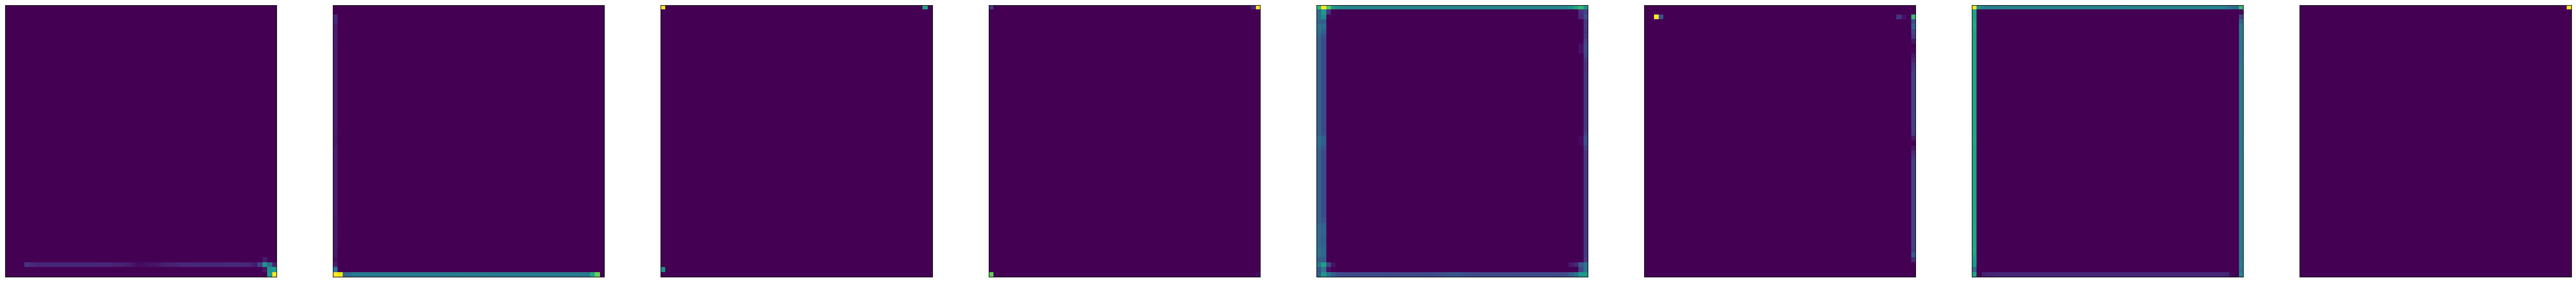

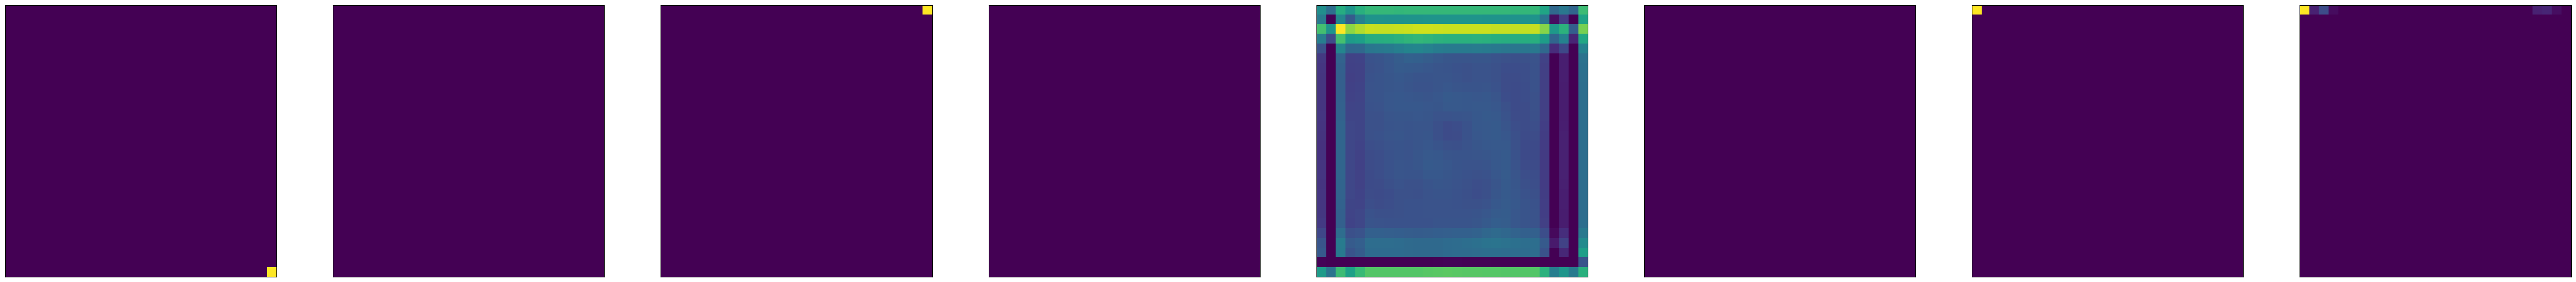

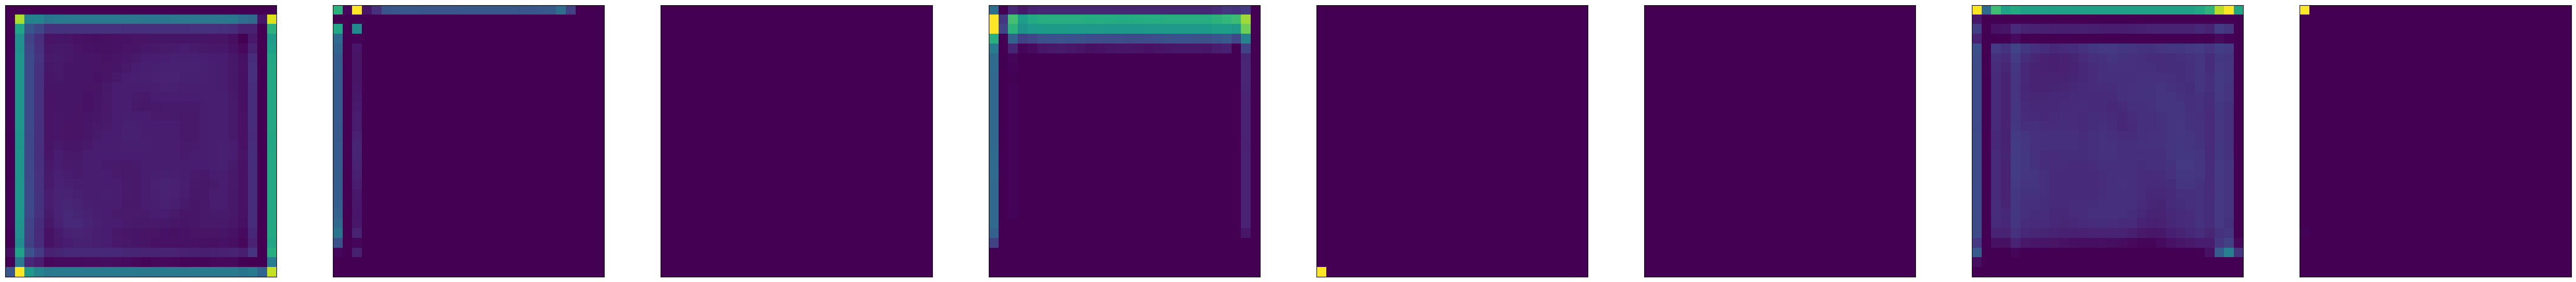

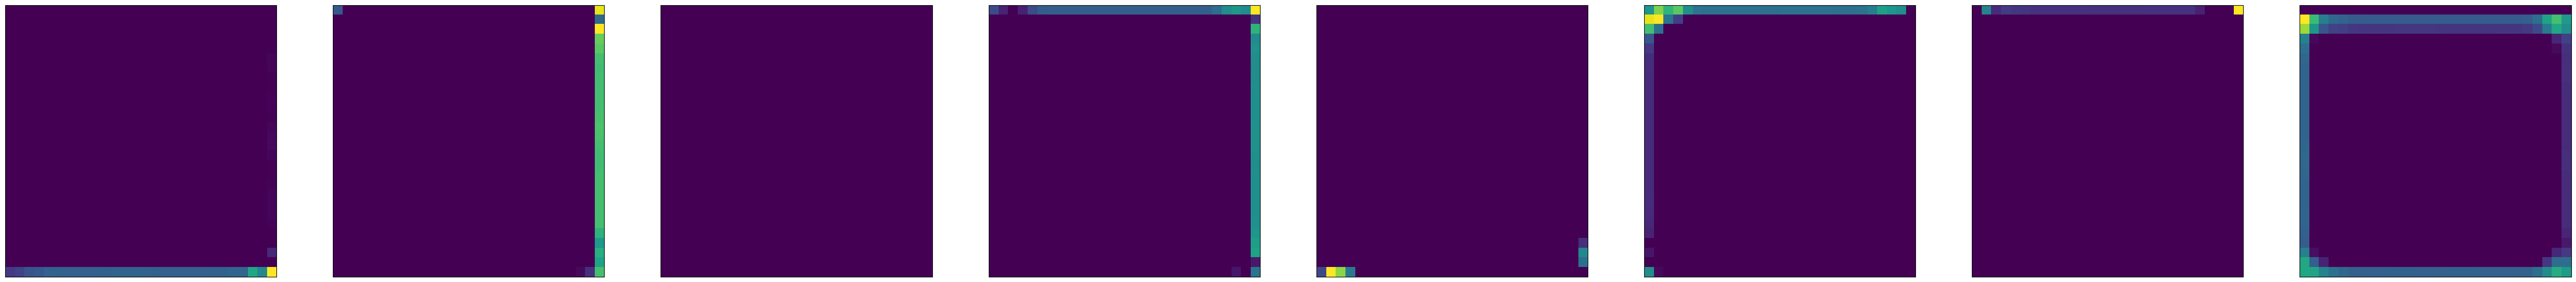

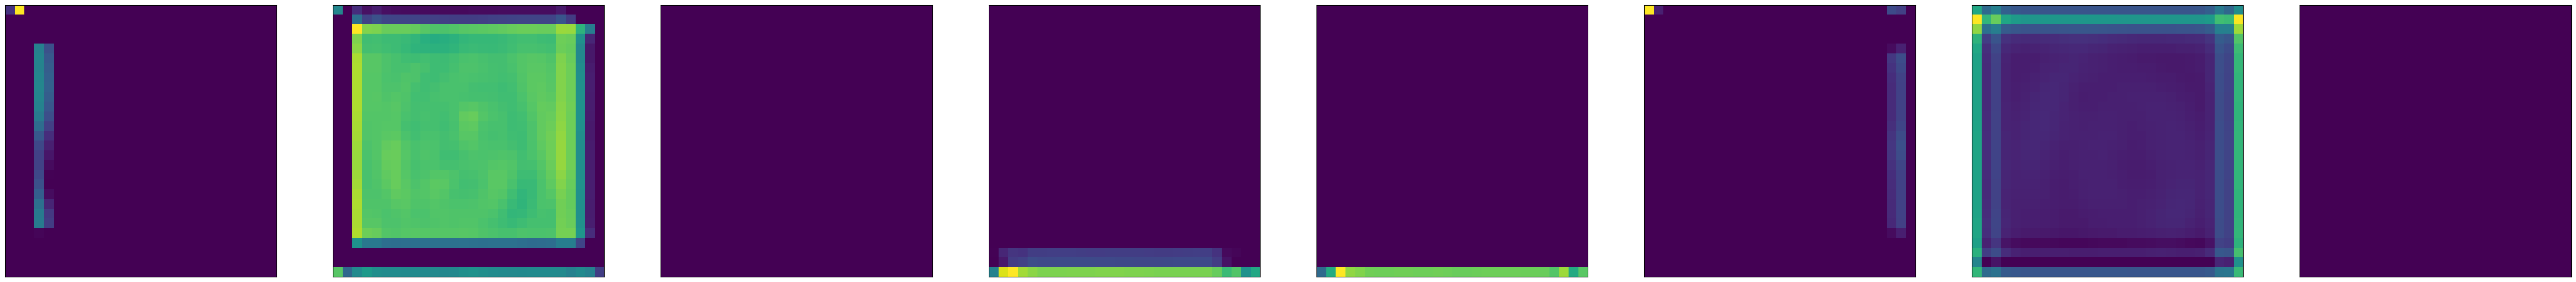

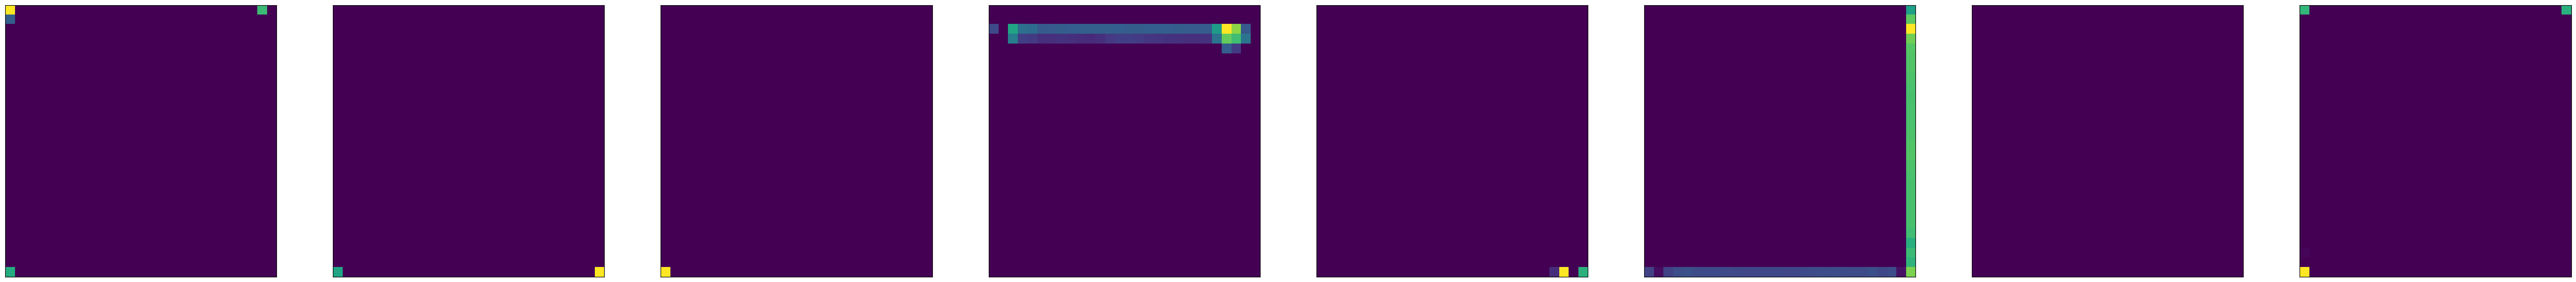

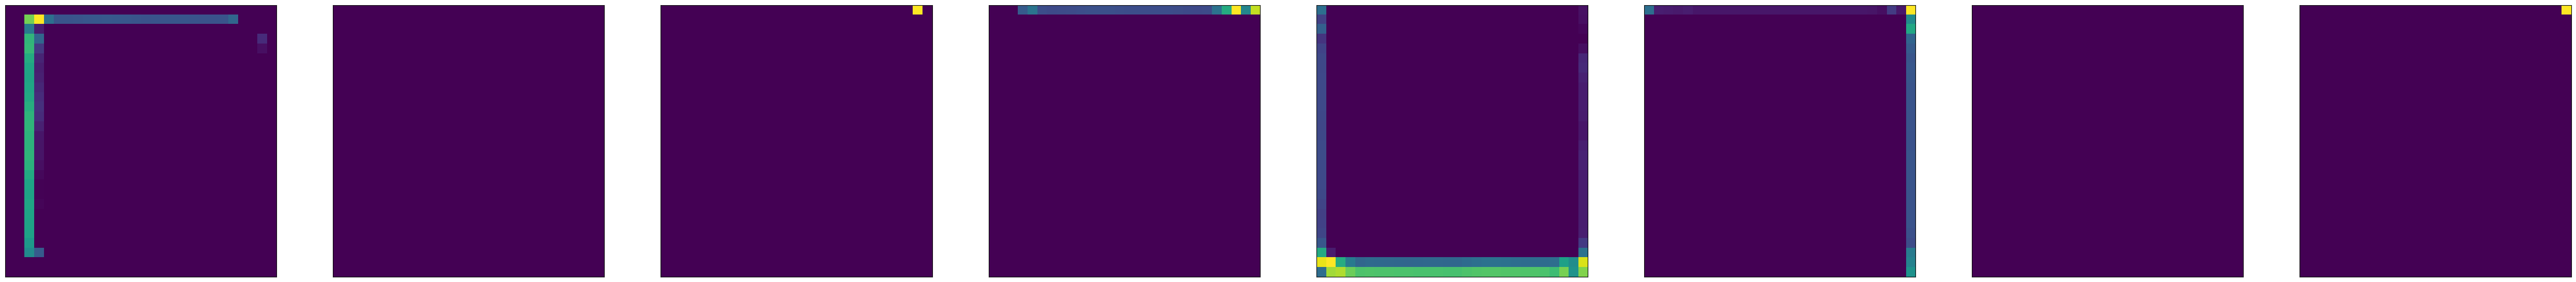

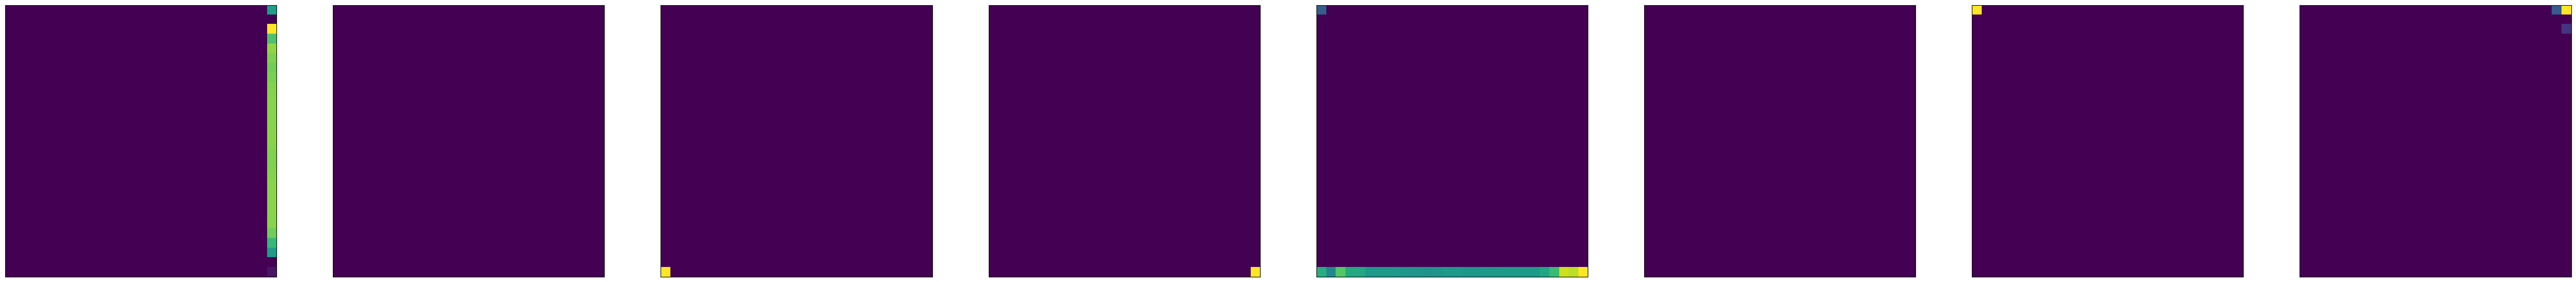

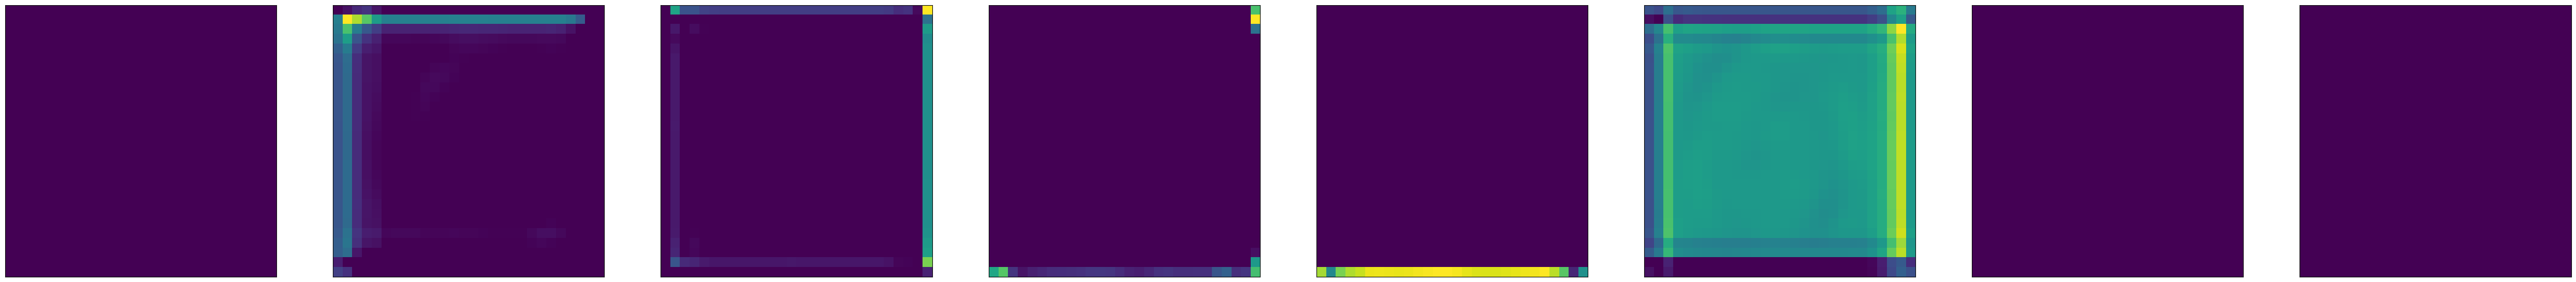

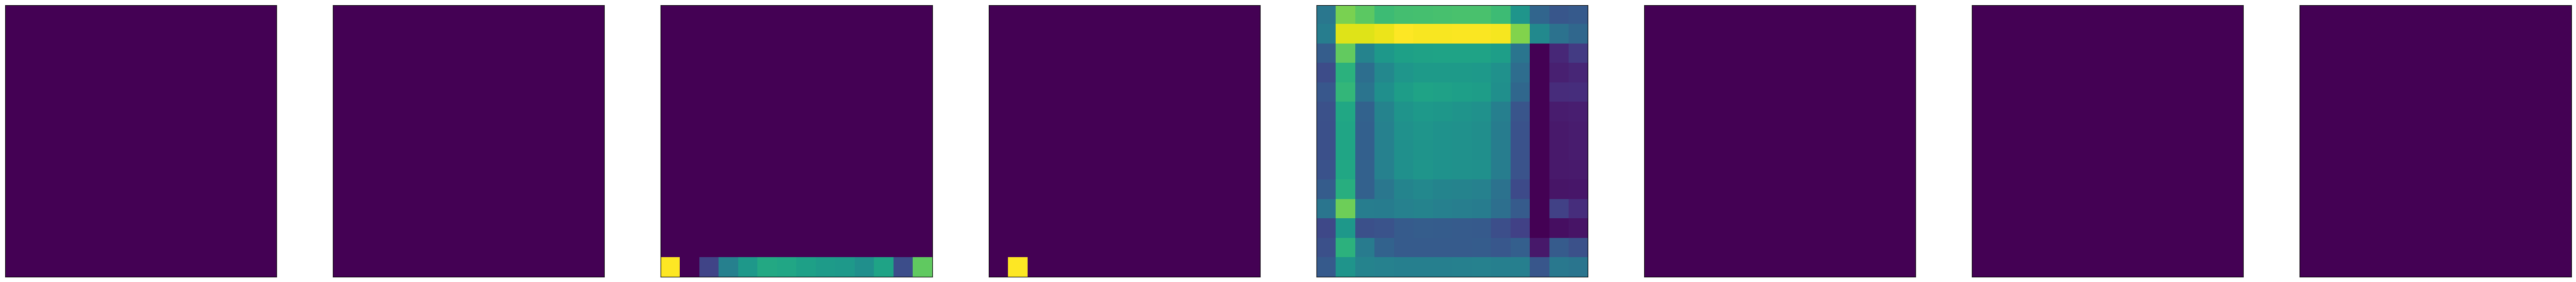

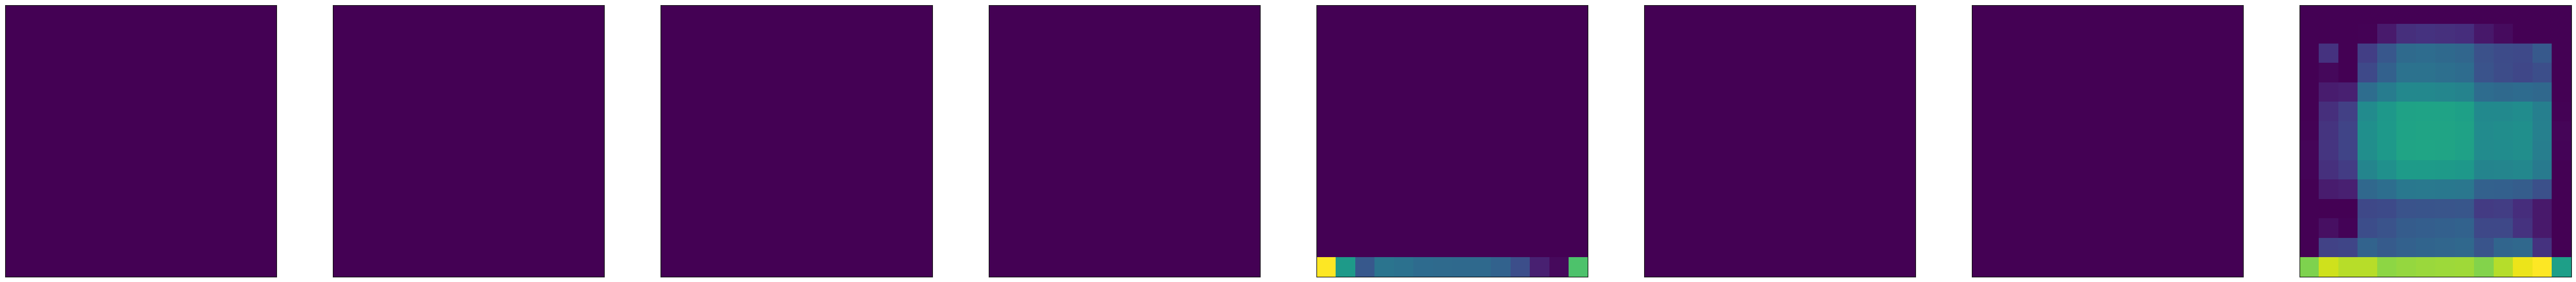

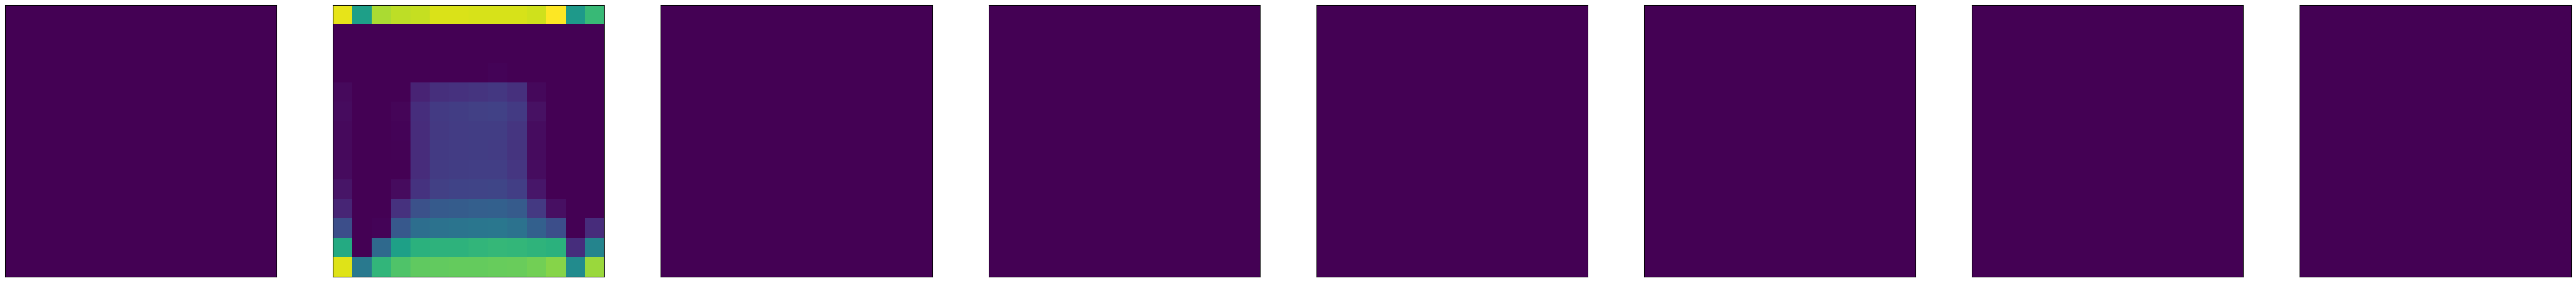

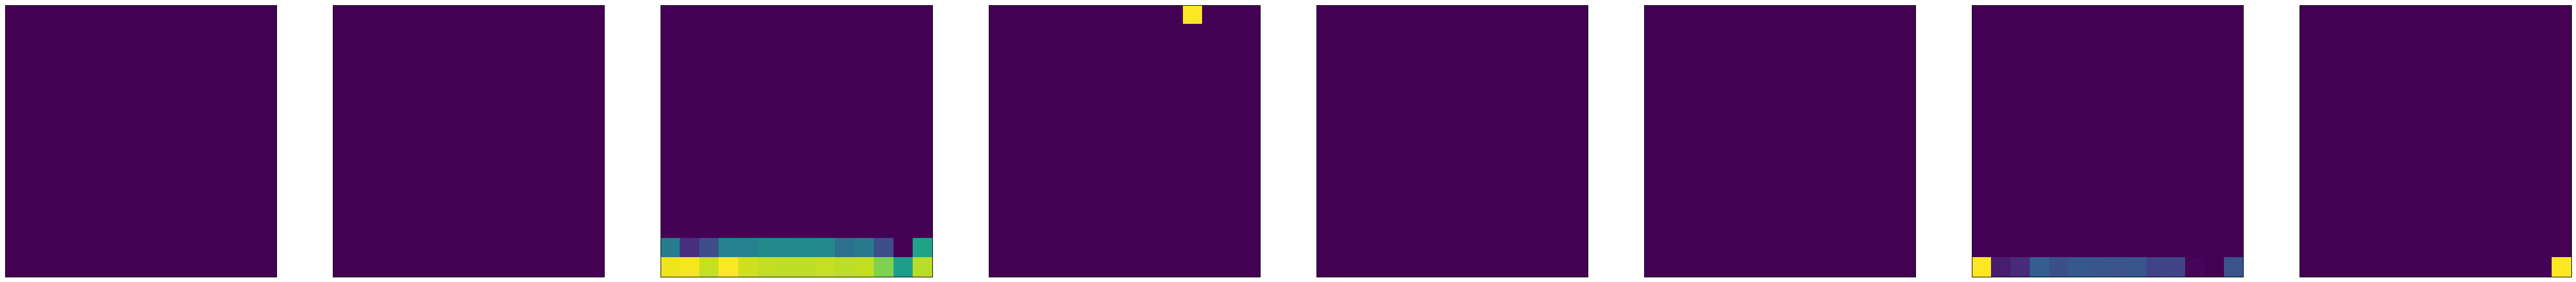

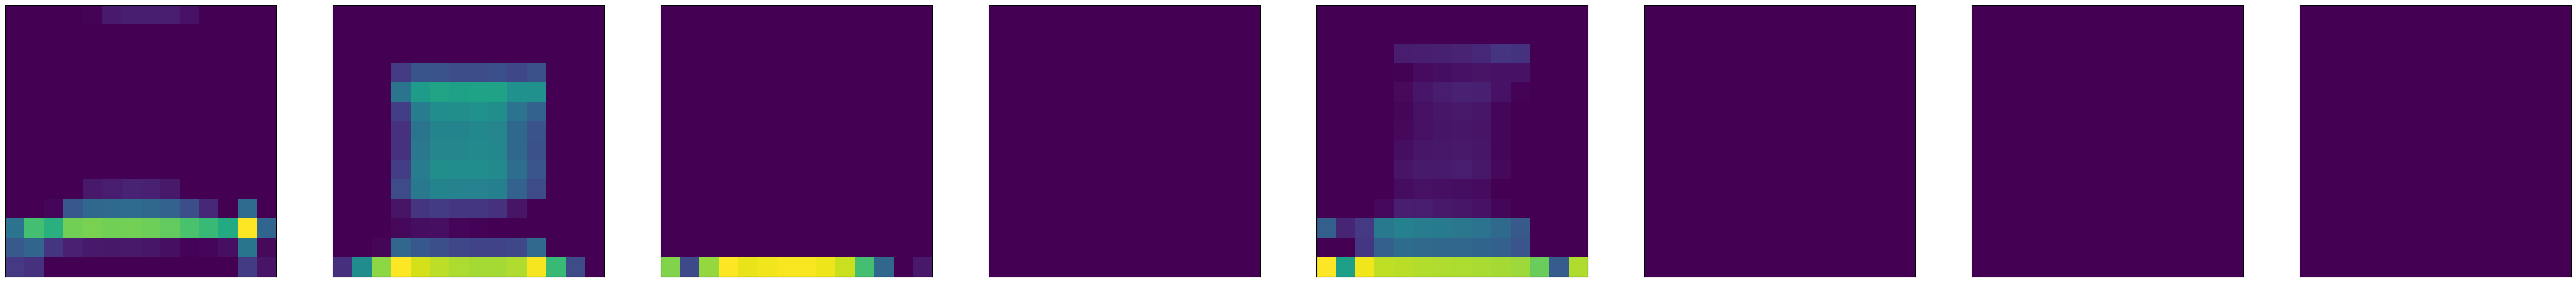

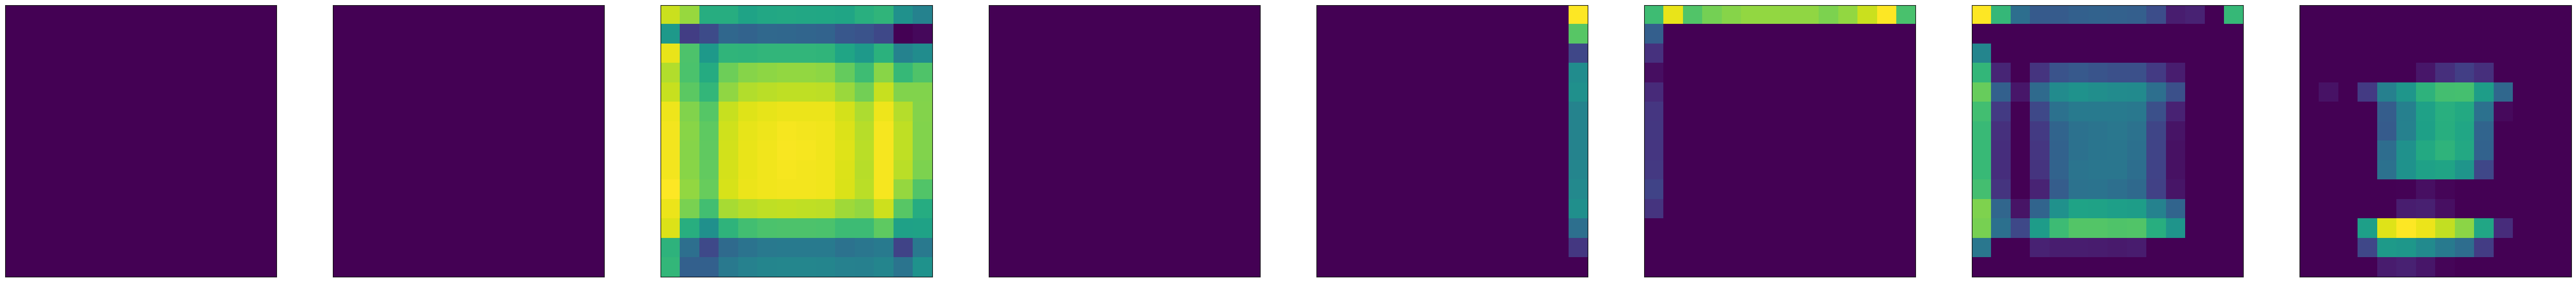

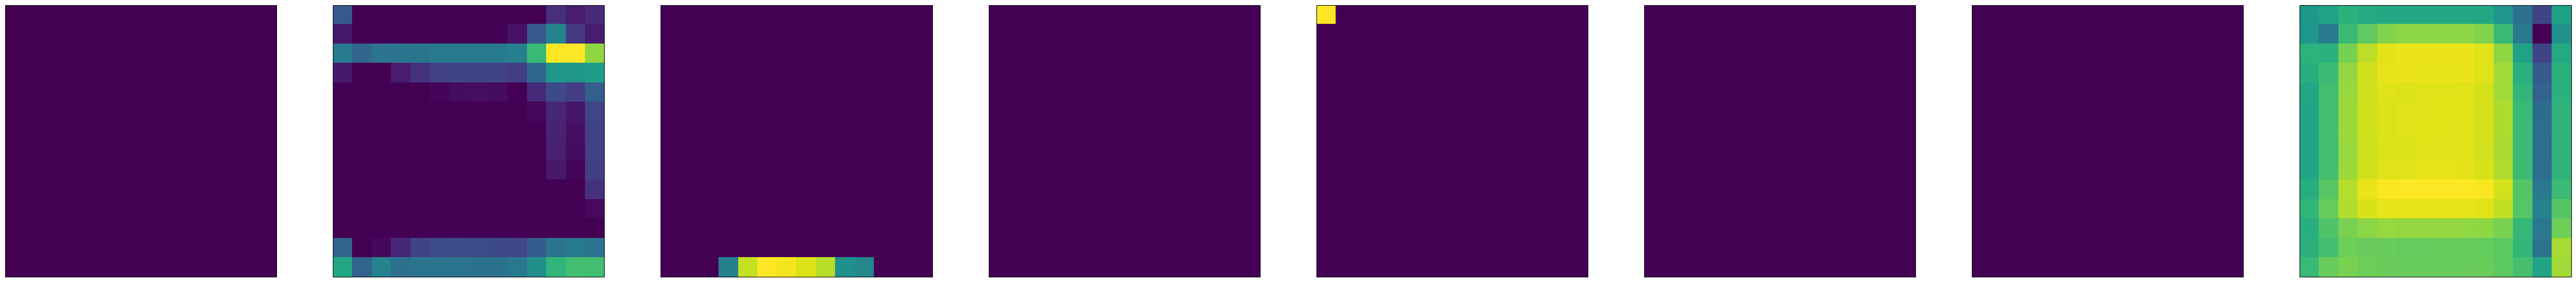

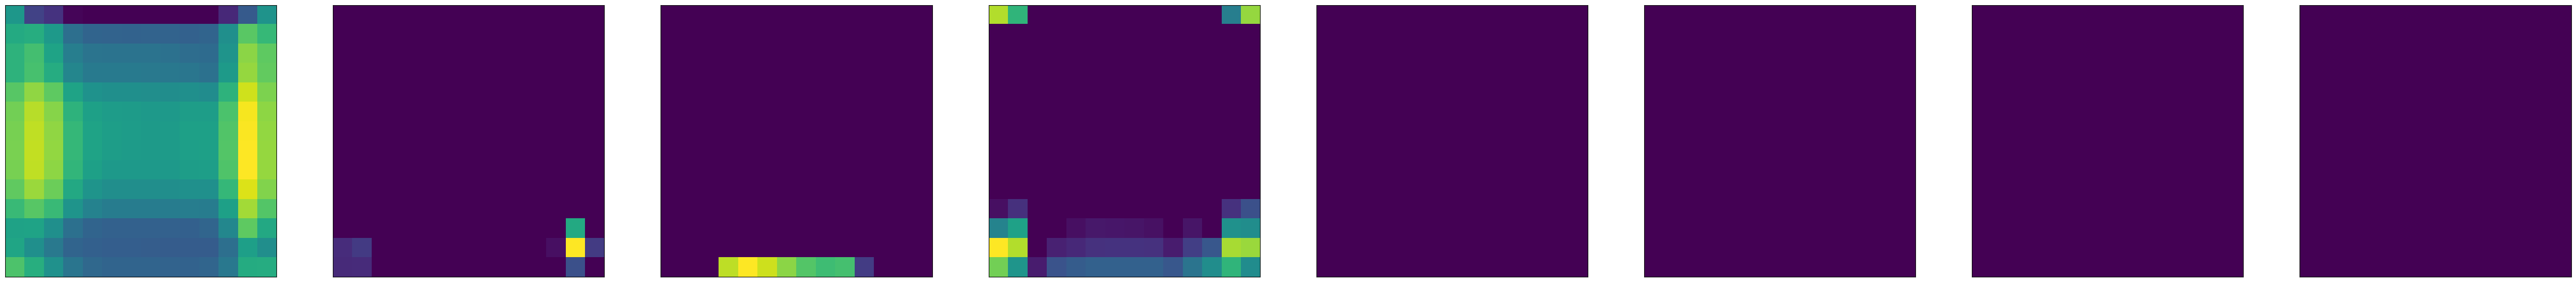

In [26]:

# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        plt.figure(figsize=(64,64))
        for _ in range(square):
           

        # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
			
			# plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
            ix += 1
	# show the figure

        
    plt.show()

In [29]:
from keras import layers
from keras.optimizers import Adam,RMSprop



num_class=1
base_model = VGG16(weights='imagenet', include_top=False)
# Create a Sequential model

vgg_16 = Sequential()
vgg_16.add(base_model)
vgg_16.add(Dropout(0.3))
vgg_16.add(Flatten())
vgg_16.add(Dropout(0.5))
vgg_16.add(Dense(units=num_class, activation='relu'))

# Set the VGG16 layers as non-trainable
vgg_16.layers[0].trainable = False

# Compile the model
vgg_16.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy']
)

# Print model summary
vgg_16.summary()
import time 
# Train the model
start = time.time()
vgg16_history = vgg_16.fit(
    X_train_prep,
    y_train,
    epochs=120,
    validation_data=(X_val_prep, y_val)
)
end = time.time()
print("Training time:", end - start)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.4131 - loss: 7.2222 - val_accuracy: 0.4603 - val_loss: 4.0205
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 10s/step - accuracy: 0.5347 - loss: 5.3397 - val_accuracy: 0.6825 - val_loss: 3.5999
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6300 - loss: 4.5101 - val_accuracy: 0.6825 - val_loss: 4.3954
Epoch 4/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.6923 - loss: 3.5865 - val_accuracy: 0.7302 - val_loss: 1.8850
Epoch 5/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6003 - loss: 4.1296 - val_accuracy: 0.7302 - val_loss: 1.5085
Epoch 6/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.6950 - loss: 3.7080 - val_accuracy: 0.8095 - val_loss: 1.9895
Epoch 7/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.7133 - loss: 3.3817 - val_accuracy: 0.6667 - val_loss: 3.1411
Epoch 8/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.7245 - loss: 3.2785 - val_accuracy: 0.8095 - val_loss: 1.983

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.8516 - loss: 1.7915 - val_accuracy: 0.8095 - val_loss: 2.8633
Epoch 53/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.8361 - loss: 1.5240 - val_accuracy: 0.8095 - val_loss: 2.6107
Epoch 54/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9102 - loss: 1.0212 - val_accuracy: 0.7619 - val_loss: 1.9446
Epoch 55/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9264 - loss: 0.7472 - val_accuracy: 0.7937 - val_loss: 1.9532
Epoch 56/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9007 - loss: 1.0459 - val_accuracy: 0.7937 - val_loss: 1.9277
Epoch 57/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.8959 - loss: 1.3389 - val_accuracy: 0.8095 - val_loss: 2.0056
Epoch 58/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.9034 - loss: 1.4404 - val_accuracy: 0.7937 - val_loss: 2.3770
Epoch 59/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9329 - loss: 0.6930 - val_accuracy: 0.8095 - val_loss: 1.9346
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9382 - loss: 0.4743 - val_accuracy: 0.8254 - val_loss: 1.8532
Epoch 104/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9278 - loss: 0.7576 - val_accuracy: 0.8571 - val_loss: 1.8382
Epoch 105/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.9383 - loss: 0.4813 - val_accuracy: 0.8571 - val_loss: 1.8352
Epoch 106/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9473 - loss: 0.5003 - val_accuracy: 0.8571 - val_loss: 1.8388
Epoch 107/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9602 - loss: 0.4673 - val_accuracy: 0.8413 - val_loss: 1.9252
Epoch 108/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9551 - loss: 0.4601 - val_accuracy: 0.8254 - val_loss: 1.8542
Epoch 109/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9448 - loss: 0.4552 - val_accuracy: 0.8254 - val_loss: 1.8604
Epoch 110/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9304 - loss: 0.6606 - val_accuracy: 0.8571 - val_loss: 2.064

In [31]:
#pridiction for the x _train andtestvalue
predictions =vgg_16.predict(X_test_prep)
predictions =[1 if x>0.5 else 0 for x in predictions  ]
(_,train_accuracy)=vgg_16.evaluate(X_val_prep, y_val, verbose=0)

(_,test_accuracy)=vgg_16.evaluate(X_test_prep, y_test, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step


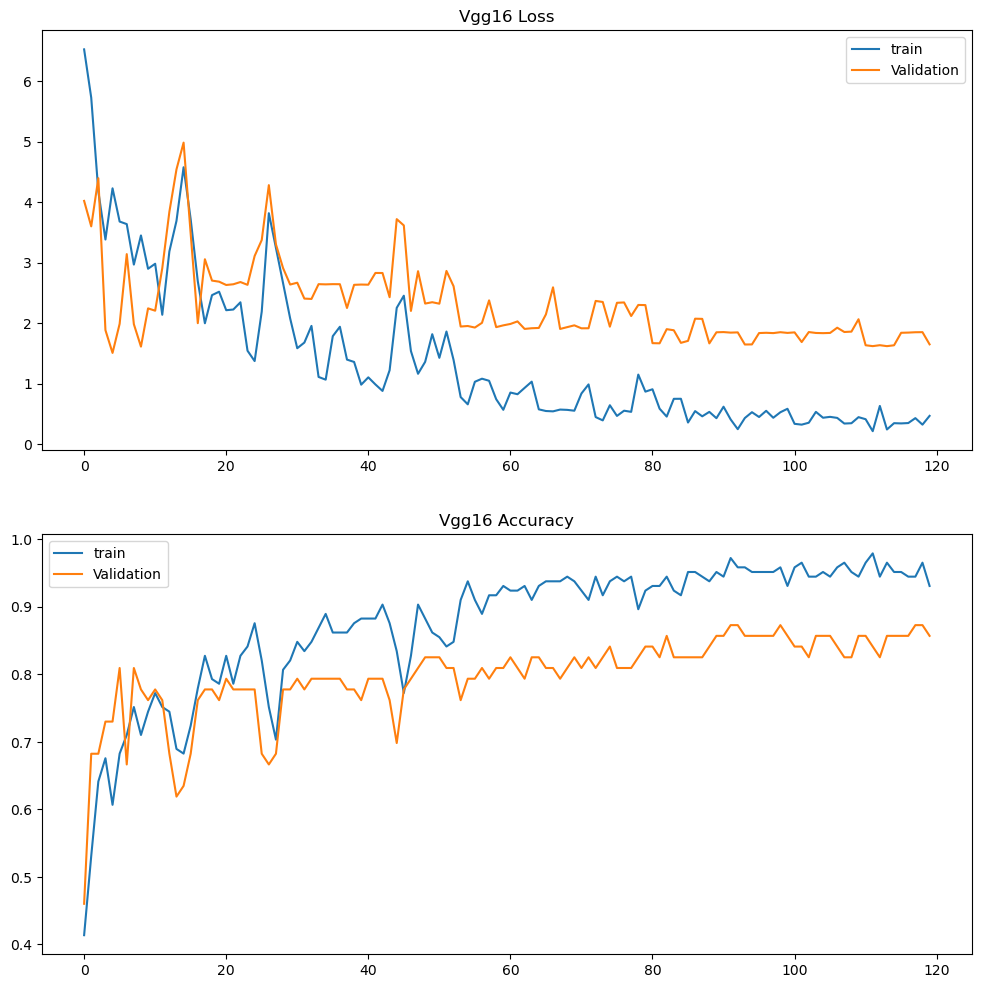

In [32]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['accuracy'], label='train')
pyplot.plot(vgg16_history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()

In [33]:
print('Train: %.3f, Test: %.3f' % (train_accuracy, test_accuracy))

Train: 0.857, Test: 0.838


In [ ]:
#RESNET50
from keras.applications import ResNet50
NUM_CLASSES = 1
resnet50_x = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet50 = Sequential()
resnet50.add(resnet50_x)
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Flatten())
resnet50.add(layers.Dropout(0.6))
resnet50.add(layers.Dense(NUM_CLASSES, activation='relu'))

resnet50.layers[0].trainable = False

resnet50.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

resnet50.summary()

# Train the model
start = time.time()
vgg16_history = resnet50.fit(
    X_train_prep,
    y_train,
    epochs=120,
    validation_data=(X_val_prep, y_val)
)
end = time.time()
print("Training time:", end - start)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5871 - loss: 5.8814 - val_accuracy: 0.6508 - val_loss: 5.0887
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5150 - loss: 6.5879 - val_accuracy: 0.6667 - val_loss: 5.3034
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5287 - loss: 6.7574 - val_accuracy: 0.6667 - val_loss: 5.3034
Epoch 4/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6664 - loss: 5.1212 - val_accuracy: 0.6667 - val_loss: 5.3034
Epoch 5/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5474 - loss: 6.8541 - val_accuracy: 0.6667 - val_loss: 5.3034
Epoch 6/120


In [ ]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['accuracy'], label='train')
pyplot.plot(vgg16_history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()